# Bilbiotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

In [2]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install graphviz

# Analise Dados

In [3]:
dados_brutos = 'Pesquisa_satisfacao/pesquisa_dados_brutos.csv'

In [4]:
dados_b=pd.read_csv(dados_brutos, encoding = 'utf-8')
dados_b.head()

C:\Users\asslea01\AppData\Local\Temp\ipykernel_32336\1729599004.py:1: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  dados_b=pd.read_csv(dados_brutos, encoding = 'utf-8')


ID_IP SERVICO  MARCA ESTADO  MODALIDADE  MUNICIPIO  COD_IBGE        DATA  \
0  2672016     POS  ALGAR     GO         NaN  Itumbiara   5211503  13/08/2021   
1  2672045     POS  ALGAR     GO         NaN  S?o Sim?o   5220405    9/8/2021   
2  2672073     POS  ALGAR     GO         NaN  Itumbiara   5211503    6/8/2021   
3  2672074     POS  ALGAR     GO         NaN  S?o Sim?o   5220405    9/8/2021   
4  2672084     POS  ALGAR     GO         NaN  Itumbiara   5211503  13/10/2021   

   ANO_BASE  SG1  ...  E1_5  E1_996  E1_999  ID1  ID2   ID3  ID3a  ID5  A1  \
0      2021  7.0  ...   NaN     NaN     NaN    4    2  4000   3.0    2   5   
1      2021  8.0  ...   NaN     NaN     NaN    4    4  6000   4.0    2   5   
2      2021  8.0  ...   5.0     NaN     NaN    6    3  8000   5.0    2   5   
3      2021  9.0  ...   5.0     NaN     NaN    7    2  5000   4.0    2   5   
4      2021  6.0  ...   NaN     NaN     NaN    9    1  3000   3.0    2   6   

          PESO  
0  0.026701412  
1  0.026701412  
2  0.026701412  
3  0.026701412  
4  0.026701412  

[5 rows x 95 columns]

In [5]:
#Remoção de colunas sem especificação

dados_b = dados_b.drop(['ISG','QAD','QAT','QIC','QF','QCR','QA4_98','QA4_99','E1_996','E1_999','PESO'],axis=1)

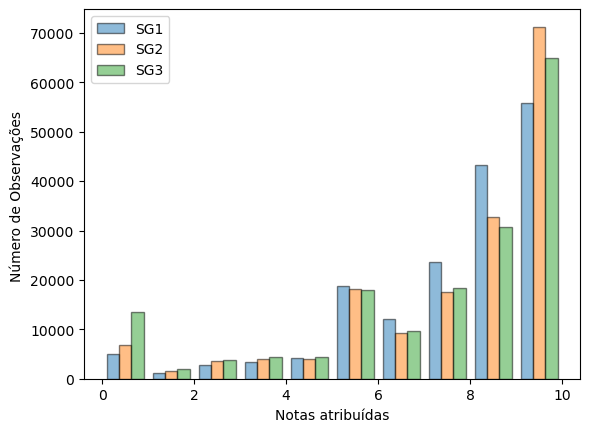

In [31]:
plt.hist([dados_b['SG1'], dados_b['SG2'], dados_b['SG3']], bins=10, edgecolor='black', alpha=0.5, label=['SG1', 'SG2', 'SG3'])

plt.legend()
plt.xlabel('Notas atribuídas')
plt.ylabel('Número de Observações ')
plt.savefig('histograma1.png', dpi=500)
plt.show()

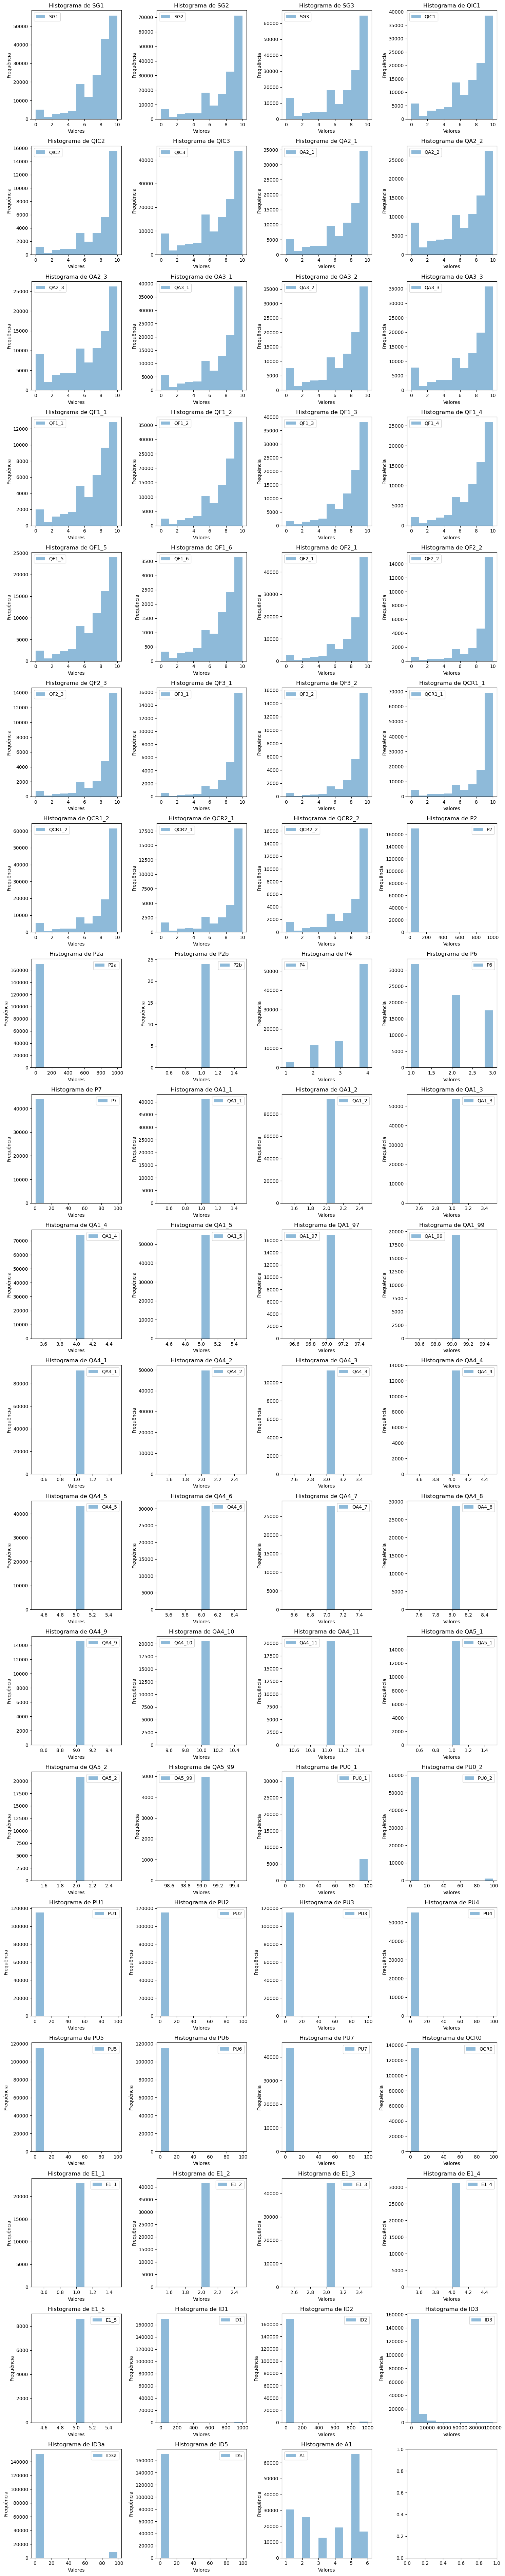

In [119]:
#Plotagem histograma de variaveis originais do dataset

colunas_selecionadas = dados_b.columns[dados_b.columns.get_loc('SG1'):]

histogramas_por_linha = 4

num_linhas = len(colunas_selecionadas) // histogramas_por_linha
if len(colunas_selecionadas) % histogramas_por_linha != 0:
    num_linhas += 1

fig, axs = plt.subplots(num_linhas, histogramas_por_linha, figsize=(15, 4 * num_linhas))

for i, coluna in enumerate(colunas_selecionadas):
    linha = i // histogramas_por_linha
    coluna_subplot = i % histogramas_por_linha
    
    axs[linha, coluna_subplot].hist(dados_b[coluna], bins=10, alpha=0.5, label=coluna)
    
  
    axs[linha, coluna_subplot].set_xlabel('Valores')
    axs[linha, coluna_subplot].set_ylabel('Frequência')
    axs[linha, coluna_subplot].set_title(f'Histograma de {coluna}')
    axs[linha, coluna_subplot].legend()


plt.tight_layout()
plt.show()

# Divisão Datasets

In [6]:
#Serviço Banda Larga
banda_larga = dados_b[dados_b['SERVICO'] == 'SCM'].copy()

#Serviço telefonia fixa
telefonia_fixa = dados_b[dados_b['SERVICO'] == 'STFC'].copy()

#Serviço TV assinatura
tv_assinatura = dados_b[dados_b['SERVICO'] == 'SEAC'].copy()

#Serviço Telefonia móvel pós pago
movel_pospago = dados_b[dados_b['SERVICO'] == 'POS'].copy()

#Serviço Telefonia móvel pré pago
movel_prepago = dados_b[dados_b['SERVICO'] == 'PRE'].copy()

In [6]:
datasets = [banda_larga, telefonia_fixa, tv_assinatura, movel_pospago, movel_prepago]

for i, dataset in enumerate(datasets, start=1):
    print(f"Número de linhas em dataset{i}: {len(dataset)}")

for i, dataset in enumerate(datasets, 1):
    numero_de_colunas = dataset.shape[1]  # ou len(dataset.columns)
    print(f'Número de colunas no dataset {i}: {numero_de_colunas}')

Número de linhas em dataset1: 43865
Número de linhas em dataset2: 26345
Número de linhas em dataset3: 28164
Número de linhas em dataset4: 38099
Número de linhas em dataset5: 33652
Número de colunas no dataset 1: 84
Número de colunas no dataset 2: 84
Número de colunas no dataset 3: 84
Número de colunas no dataset 4: 84
Número de colunas no dataset 5: 84


# Datawrangling 

#Preencher valores NaN pela moda (Não é uma boa opção, pois os dados estão desbalanceados para os valores mais altos e a utilização da moda em valores NaN só acentua esse desbalanceamento.)

#Calcula a moda
moda_coluna1 = banda_larga['QA3_1'].mode()[0]  
moda_coluna2 = banda_larga['QA3_2'].mode()[0]
moda_coluna3 = banda_larga['QA3_3'].mode()[0]
moda_coluna4 = banda_larga['QF1_1'].mode()[0]  
moda_coluna5 = banda_larga['QF1_2'].mode()[0]
moda_coluna6 = banda_larga['QF1_3'].mode()[0]
moda_coluna7 = banda_larga['QF1_4'].mode()[0]
moda_coluna8 = banda_larga['QCR1_1'].mode()[0]
moda_coluna9 = banda_larga['QCR1_2'].mode()[0]

#preenche NaN pela moda
banda_larga['QA3_1'] = banda_larga['QA3_1'].fillna(moda_coluna1)
banda_larga['QA3_2'] = banda_larga['QA3_2'].fillna(moda_coluna2)
banda_larga['QA3_3'] = banda_larga['QA3_3'].fillna(moda_coluna3)
banda_larga['QF1_1'] = banda_larga['QF1_1'].fillna(moda_coluna4)
banda_larga['QF1_2'] = banda_larga['QF1_2'].fillna(moda_coluna5)
banda_larga['QF1_3'] = banda_larga['QF1_3'].fillna(moda_coluna6)
banda_larga['QF1_4'] = banda_larga['QF1_4'].fillna(moda_coluna7)
banda_larga['QCR1_1'] = banda_larga['QCR1_1'].fillna(moda_coluna8)
banda_larga['QCR1_2'] = banda_larga['QCR1_2'].fillna(moda_coluna9)

print(banda_larga[['QA3_1','QA3_2','QA3_3']])

In [7]:
pd.set_option('display.max_rows', None)
# Calcular o número de NaN em cada coluna
NaN_bandlarg1 = banda_larga.isna().sum()
NaN_telfix1 = telefonia_fixa.isna().sum()
NaN_tvassinatura1 = tv_assinatura.isna().sum()
NaN_movelpospago1 = movel_pospago.isna().sum()
NaN_movelprepago1 = movel_prepago.isna().sum()

# Concatenar os resultados ao longo das colunas
resultados_concatenados = pd.concat([NaN_bandlarg1, NaN_telfix1, NaN_tvassinatura1, NaN_movelpospago1, NaN_movelprepago1], axis=1)

# Renomear as colunas para indicar o conjunto de dados
resultados_concatenados.columns = ['banda_larga', 'telefonia_fixa', 'tv_assinatura', 'movel_pospago', 'movel_prepago']

# Imprimir os resultados
print(resultados_concatenados)
pd.reset_option('display.max_rows')

            banda_larga  telefonia_fixa  tv_assinatura  movel_pospago  \
ID_IP                 0               0              0              0   
SERVICO               0               0              0              0   
MARCA                 0               0              0              0   
ESTADO                0               0              0              0   
MODALIDADE        43865           26345          28164          38099   
MUNICIPIO             0               0              0              0   
COD_IBGE              0               0              0              0   
DATA                  0               0              0              0   
ANO_BASE              0               0              0              0   
SG1                  13              29             23             19   
SG2                 353             331            220            191   
SG3                  98             138             81             78   
QIC1                287           26345          28

In [7]:
#Dummizar variaveis categoricas

#banda larga
banda_larga[['QA1_1', 'QA1_2', 'QA1_3', 'QA1_4', 'QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','E1_1','E1_2','E1_3','E1_4','E1_5']] = banda_larga[['QA1_1', 'QA1_2', 'QA1_3', 'QA1_4', 'QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','E1_1','E1_2','E1_3','E1_4','E1_5']].fillna(0).applymap(lambda x: 1 if x != 0 else 0)

#telefonia fixa
telefonia_fixa[['QA1_1', 'QA1_2', 'QA1_3', 'QA1_4', 'QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','E1_1','E1_2','E1_3','E1_4','E1_5']] = telefonia_fixa[['QA1_1', 'QA1_2', 'QA1_3', 'QA1_4', 'QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','E1_1','E1_2','E1_3','E1_4','E1_5']].fillna(0).applymap(lambda x: 1 if x != 0 else 0)

#TV assinatura
tv_assinatura[['QA1_1', 'QA1_2', 'QA1_3', 'QA1_4', 'QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','E1_1','E1_2','E1_3','E1_4','E1_5']] = tv_assinatura[['QA1_1', 'QA1_2', 'QA1_3', 'QA1_4', 'QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','E1_1','E1_2','E1_3','E1_4','E1_5']].fillna(0).applymap(lambda x: 1 if x != 0 else 0)

#telefonia movel pós-paga
movel_pospago[['QA1_1', 'QA1_2', 'QA1_3', 'QA1_4', 'QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','E1_1','E1_2','E1_3','E1_4','E1_5']] = movel_pospago[['QA1_1', 'QA1_2', 'QA1_3', 'QA1_4', 'QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','E1_1','E1_2','E1_3','E1_4','E1_5']].fillna(0).applymap(lambda x: 1 if x != 0 else 0)

#telefonia movel pré-paga
movel_prepago[['QA1_1', 'QA1_2', 'QA1_3', 'QA1_4', 'QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','E1_1','E1_2','E1_3','E1_4','E1_5']] = movel_prepago[['QA1_1', 'QA1_2', 'QA1_3', 'QA1_4', 'QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','E1_1','E1_2','E1_3','E1_4','E1_5']].fillna(0).applymap(lambda x: 1 if x != 0 else 0)




In [34]:
pd.set_option('display.max_rows', None)
# Calcular o número de NaN em cada coluna
NaN_bandlarg1 = banda_larga.isna().sum()
NaN_telfix1 = telefonia_fixa.isna().sum()
NaN_tvassinatura1 = tv_assinatura.isna().sum()
NaN_movelpospago1 = movel_pospago.isna().sum()
NaN_movelprepago1 = movel_prepago.isna().sum()

# Concatenar os resultados ao longo das colunas
resultados_concatenados = pd.concat([NaN_bandlarg1, NaN_telfix1, NaN_tvassinatura1, NaN_movelpospago1, NaN_movelprepago1], axis=1)

# Renomear as colunas para indicar o conjunto de dados
resultados_concatenados.columns = ['banda_larga', 'telefonia_fixa', 'tv_assinatura', 'movel_pospago', 'movel_prepago']

# Imprimir os resultados
print(resultados_concatenados)
pd.reset_option('display.max_rows')

            banda_larga  telefonia_fixa  tv_assinatura  movel_pospago  \
ID_IP                 0               0              0              0   
SERVICO               0               0              0              0   
MARCA                 0               0              0              0   
ESTADO                0               0              0              0   
MODALIDADE        43865           26345          28164          38099   
MUNICIPIO             0               0              0              0   
COD_IBGE              0               0              0              0   
DATA                  0               0              0              0   
ANO_BASE              0               0              0              0   
SG1                  13              29             23             19   
SG2                 353             331            220            191   
SG3                  98             138             81             78   
QIC1                287           26345          28

In [8]:
# Calcular o número de NaN em cada coluna
NaN_bandalarga = banda_larga.isna().sum()
Nan_telefoniafixa = telefonia_fixa.isna().sum()
NaN_tv_assinatura = tv_assinatura.isna().sum()
NaN_movel_pospago = movel_pospago.isna().sum()
NaN_movel_prepago = movel_prepago.isna().sum()

# Ajustar os índices para garantir que estejam alinhados
NaN_bandalarga.index = banda_larga.columns
Nan_telefoniafixa.index = telefonia_fixa.columns
NaN_tv_assinatura.index = tv_assinatura.columns
NaN_movel_pospago.index = movel_pospago.columns
NaN_movel_prepago.index = movel_prepago.columns

# Aplicar a condição
colunas_a_remover_bandalarga = NaN_bandalarga[NaN_bandalarga > (len(banda_larga) * 0.33)]
colunas_a_remover_telefoniafixa = Nan_telefoniafixa[Nan_telefoniafixa > (len(telefonia_fixa) * 0.33)]
colunas_a_remover_tvass = NaN_tv_assinatura[NaN_tv_assinatura > (len(tv_assinatura) * 0.33)]
colunas_a_remover_pospago = NaN_movel_pospago[NaN_movel_pospago > (len(movel_pospago) * 0.33)]
colunas_a_remover_prepago = NaN_movel_prepago[NaN_movel_prepago > (len(movel_prepago) * 0.33)]

#Remover colunas 
colunas_a_remover_bandalarga = colunas_a_remover_bandalarga.index.tolist()
colunas_a_remover_telefoniafixa = colunas_a_remover_telefoniafixa.index.tolist()
colunas_a_remover_tvass = colunas_a_remover_tvass.index.tolist()
colunas_a_remover_pospago = colunas_a_remover_pospago.index.tolist()
colunas_a_remover_prepago = colunas_a_remover_prepago.index.tolist()


bandlarg = banda_larga.drop(columns=colunas_a_remover_bandalarga)
telfix = telefonia_fixa.drop(columns=colunas_a_remover_telefoniafixa)
tvass = tv_assinatura.drop(columns=colunas_a_remover_tvass)
pospago = movel_pospago.drop(columns=colunas_a_remover_pospago)
prepago = movel_prepago.drop(columns=colunas_a_remover_prepago)

datasets=[bandlarg,telfix,tvass,pospago,prepago]

for i, dataset in enumerate(datasets, 1):
    numero_de_colunas = dataset.shape[1]  # ou len(dataset.columns)
    print(f'Número de colunas no dataset {i}: {numero_de_colunas}')


Número de colunas no dataset 1: 59
Número de colunas no dataset 2: 47
Número de colunas no dataset 3: 46
Número de colunas no dataset 4: 58
Número de colunas no dataset 5: 54


In [10]:
pd.set_option('display.max_rows', None)
# Calcular o número de NaN em cada coluna
NaN_bandlarg2 = bandlarg.isna().sum()
NaN_telfix2 = telfix.isna().sum()
NaN_tvassinatura2 = tvass.isna().sum()
NaN_movelpospago2 = pospago.isna().sum()
NaN_movelprepago2 = prepago.isna().sum()

# Concatenar os resultados ao longo das colunas
resultados_concatenados = pd.concat([NaN_bandlarg2, NaN_telfix2, NaN_tvassinatura2, NaN_movelpospago2, NaN_movelprepago2], axis=1)

# Renomear as colunas para indicar o conjunto de dados
resultados_concatenados.columns = ['bandlarg', 'telfix', 'tvass', 'pospago', 'prepago']

# Imprimir os resultados
print(resultados_concatenados)
pd.reset_option('display.max_rows')

           bandlarg  telfix   tvass  pospago  prepago
ID_IP           0.0     0.0     0.0      0.0      0.0
SERVICO         0.0     0.0     0.0      0.0      0.0
MARCA           0.0     0.0     0.0      0.0      0.0
ESTADO          0.0     0.0     0.0      0.0      0.0
MUNICIPIO       0.0     0.0     0.0      0.0      0.0
COD_IBGE        0.0     0.0     0.0      0.0      0.0
DATA            0.0     0.0     0.0      0.0      0.0
ANO_BASE        0.0     0.0     0.0      0.0      0.0
SG1            13.0    29.0    23.0     19.0     23.0
SG2           353.0   331.0   220.0    191.0    196.0
SG3            98.0   138.0    81.0     78.0     93.0
QIC1          287.0     NaN     NaN    175.0    157.0
QIC3          946.0   864.0   605.0    356.0      NaN
QA3_1       14167.0     NaN     NaN  11390.0      NaN
QA3_2       14174.0     NaN     NaN  11404.0      NaN
QA3_3       14173.0     NaN     NaN  11376.0      NaN
QF1_1          90.0     NaN     NaN      NaN      NaN
QF1_2        2541.0     NaN 

In [9]:
def limpar_dados(dataset, colunas_dropna, coluna_condicao):
    # Drop NaN nas colunas especificadas
    dataset = dataset.dropna(subset=colunas_dropna)
    
    # Ajustar índices após dropna
    dataset.reset_index(drop=True, inplace=True)
    
    # Filtrar com base na condição na coluna especificada
    dataset = dataset.loc[dataset[coluna_condicao] <= 100]
    
    return dataset

# Substitua 'bandlarg', 'telfix', 'tvass', 'pospago', 'prepago' pelos seus DataFrames
bandlarg = limpar_dados(bandlarg, ['SG1','SG2','SG3','QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_1','QF1_2','QF1_3','QF1_4','QCR1_1','QCR1_2','ID3a'], 'P2')
telfix = limpar_dados(telfix, ['SG1','SG2','SG3','QIC3','QF2_1','QF2_2','QF2_3','QCR1_1','QCR1_2','ID3a'], 'P2')
tvass = limpar_dados(tvass, ['SG1','SG2','SG3','QIC3','QF3_1','QF3_2','QCR1_1','QCR1_2','ID3a'], 'P2')
pospago = limpar_dados(pospago, ['SG1','SG2','SG3','QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_2','QF1_3','QF2_1','QF1_5','QCR1_1','QCR1_2','ID3a'], 'P2')
prepago = limpar_dados(prepago, ['SG1','SG2','SG3','QIC1','QIC2','QF1_2','QF1_3','QF2_1','QF1_5','ID3a','QCR2_1','QCR2_2'], 'P2')


print("Número de linhas após a limpeza:")
print("bandlarg:", bandlarg.shape[0])
print("telfix:", telfix.shape[0])
print("tvass:", tvass.shape[0])
print("pospago:", pospago.shape[0])
print("prepago:", prepago.shape[0])

Número de linhas após a limpeza:
bandlarg: 18917
telfix: 17762
tvass: 22772
pospago: 17284
prepago: 17707


In [10]:
#Remover variaveis de identificação

# Lista de colunas a serem removidas
colunas_a_remover = ['ID_IP', 'SERVICO', 'MUNICIPIO', 'DATA', 'ANO_BASE']

# Substitua 'bandlarg', 'telfix', 'tvass', 'pospago', 'prepago' pelos seus DataFrames
datasets = [bandlarg, telfix, tvass, pospago, prepago]

# Iterar sobre os datasets e remover as colunas
for dataset in datasets:
    dataset.drop(colunas_a_remover, axis=1, inplace=True)


In [47]:
valores_unicosbandlarg=bandlarg['MARCA'].unique() #valores_unicosbandlarg=bandlarg['MARCA'].value_counts()
valores_unicostelfix=telfix['MARCA'].unique()
valores_unicostvass=tvass['MARCA'].unique()
valores_unicospospago=pospago['MARCA'].unique()
valores_unicosprepago=prepago['MARCA'].unique()



print(valores_unicosbandlarg)
print(valores_unicostelfix)
print(valores_unicostvass)
print(valores_unicospospago)
print(valores_unicosprepago)

['ALGAR' 'BRISANET' 'CLARO' 'MOB' 'OI' 'SKY' 'TIM' 'UNIFIQUE' 'VIVO'
 'GIGABYTE' 'VALENET']
['ALGAR' 'CLARO' 'OI' 'TIM' 'UNIFIQUE' 'VIVO']
['CLARO' 'OI' 'SKY' 'UNIFIQUE' 'VIVO']
['ALGAR' 'CLARO' 'OI' 'TIM' 'VIVO' 'OICLARO' 'OITIM' 'OIVIVO']
['ALGAR' 'CLARO' 'OI' 'TIM' 'VIVO' 'OICLARO' 'OITIM' 'OIVIVO']


In [11]:
mapeamento = {'ALGAR': 0, 'BRISANET': 1, 'CLARO': 2, 'MOB': 3, 'OI': 4, 'SKY': 5,
              'TIM': 6, 'UNIFIQUE': 7, 'VIVO': 8, 'GIGABYTE': 9, 'VALENET': 10, 'OITIM':11, 'OIVIVO':12, 'OICLARO':13}


bandlarg['MARCA'] = bandlarg['MARCA'].replace(mapeamento)
telfix['MARCA'] = telfix['MARCA'].replace(mapeamento)
tvass['MARCA'] = tvass['MARCA'].replace(mapeamento)
pospago['MARCA'] = pospago['MARCA'].replace(mapeamento)
prepago['MARCA'] = prepago['MARCA'].replace(mapeamento)

valores_unicosbandlarg=bandlarg['MARCA'].value_counts() #valores_unicosbandlarg=bandlarg['MARCA'].value_counts()
valores_unicostelfix=telfix['MARCA'].value_counts()
valores_unicostvass=tvass['MARCA'].value_counts()
valores_unicospospago=pospago['MARCA'].value_counts()
valores_unicosprepago=prepago['MARCA'].value_counts()



print(valores_unicosbandlarg)
print(valores_unicostelfix)
print(valores_unicostvass)
print(valores_unicospospago)
print(valores_unicosprepago)


2     5255
4     4215
8     3536
5     1674
6     1528
1     1221
3      603
0      393
7      215
9      150
10     127
Name: MARCA, dtype: int64
4    6779
2    4841
8    3812
6    1614
0     588
7     128
Name: MARCA, dtype: int64
5    7584
2    6347
4    5604
8    2978
7     259
Name: MARCA, dtype: int64
8     4026
6     3754
2     3482
11    2011
4     1678
13    1094
12     805
0      434
Name: MARCA, dtype: int64
6     4473
8     4240
2     3534
4     1899
11    1491
13     881
12     787
0      402
Name: MARCA, dtype: int64


In [12]:
mapeamento_estados = {
    'AC': 0,
    'AL': 1,
    'AM': 2,
    'AP': 3,
    'BA': 4,
    'CE': 5,
    'DF': 6,
    'ES': 7,
    'GO': 8,
    'MA': 9,
    'MG': 10,
    'MS': 11,
    'MT': 12,
    'PA': 13,
    'PB': 14,
    'PE': 15,
    'PI': 16,
    'PR': 17,
    'RJ': 18,
    'RN': 19,
    'RO': 20,
    'RR': 21,
    'RS': 22,
    'SC': 23,
    'SE': 24,
    'SP': 25,
    'TO': 26
}


bandlarg['ESTADO'] = bandlarg['ESTADO'].replace(mapeamento_estados)
telfix['ESTADO'] = telfix['ESTADO'].replace(mapeamento_estados)
tvass['ESTADO'] = tvass['ESTADO'].replace(mapeamento_estados)
pospago['ESTADO'] = pospago['ESTADO'].replace(mapeamento_estados)
prepago['ESTADO'] = prepago['ESTADO'].replace(mapeamento_estados)

In [12]:
pd.set_option('display.max_rows', None)
# Calcular o número de NaN em cada coluna
NaN_bandlarg2 = bandlarg.isna().sum()
NaN_telfix2 = telfix.isna().sum()
NaN_tvassinatura2 = tvass.isna().sum()
NaN_movelpospago2 = pospago.isna().sum()
NaN_movelprepago2 = prepago.isna().sum()

# Concatenar os resultados ao longo das colunas
resultados_concatenados = pd.concat([NaN_bandlarg2, NaN_telfix2, NaN_tvassinatura2, NaN_movelpospago2, NaN_movelprepago2], axis=1)

# Renomear as colunas para indicar o conjunto de dados
resultados_concatenados.columns = ['bandlarg', 'telfix', 'tvass', 'pospago', 'prepago']

# Imprimir os resultados
print(resultados_concatenados)
pd.reset_option('display.max_rows')

        bandlarg  telfix  tvass  pospago  prepago
MARCA        0.0     0.0    0.0      0.0      0.0
ESTADO       0.0     0.0    0.0      0.0      0.0
SG1          0.0     0.0    0.0      0.0      0.0
SG2          0.0     0.0    0.0      0.0      0.0
SG3          0.0     0.0    0.0      0.0      0.0
QIC1         0.0     NaN    NaN      0.0      0.0
QIC3         0.0     0.0    0.0      0.0      NaN
QA3_1        0.0     NaN    NaN      0.0      NaN
QA3_2        0.0     NaN    NaN      0.0      NaN
QA3_3        0.0     NaN    NaN      0.0      NaN
QF1_1        0.0     NaN    NaN      NaN      NaN
QF1_2        0.0     NaN    NaN      0.0      0.0
QF1_3        0.0     NaN    NaN      0.0      0.0
QF1_4        0.0     NaN    NaN      NaN      NaN
QCR1_1       0.0     0.0    0.0      0.0      NaN
QCR1_2       0.0     0.0    0.0      0.0      NaN
P2           0.0     0.0    0.0      0.0      0.0
P2a          0.0     0.0    0.0      0.0      0.0
P7           0.0     NaN    NaN      NaN      NaN


In [15]:
# Lista de datasets
datasets = [bandlarg, telfix, tvass, pospago, prepago]
nomes_datasets = ['bandlarg', 'telfix', 'tvass', 'pospago', 'prepago']

# Configurar a exibição para mostrar todas as colunas
pd.set_option('display.max_columns', None)

# Calcular e imprimir o número de NaN em cada coluna para cada dataset
for dataset, nome_dataset in zip(datasets, nomes_datasets):
    print(f"\nNúmero de NaN em cada coluna para {nome_dataset}:")
    print(dataset.isna().sum())

# Resetar as opções de exibição para o padrão
pd.reset_option('display.max_columns')



Número de NaN em cada coluna para bandlarg:
MARCA       0
ESTADO      0
COD_IBGE    0
SG1         0
SG2         0
SG3         0
QIC1        0
QIC3        0
QA3_1       0
QA3_2       0
QA3_3       0
QF1_1       0
QF1_2       0
QF1_3       0
QF1_4       0
QCR1_1      0
QCR1_2      0
P2          0
P2a         0
P7          0
QA1_1       0
QA1_2       0
QA1_3       0
QA1_4       0
QA1_5       0
QA4_1       0
QA4_2       0
QA4_3       0
QA4_4       0
QA4_5       0
QA4_6       0
QA4_7       0
QA4_8       0
QA4_9       0
QA4_10      0
QA4_11      0
PU1         0
PU2         0
PU3         0
PU5         0
PU6         0
PU7         0
QCR0        0
E1_1        0
E1_2        0
E1_3        0
E1_4        0
E1_5        0
ID1         0
ID2         0
ID3         0
ID3a        0
ID5         0
A1          0
dtype: int64

Número de NaN em cada coluna para telfix:
MARCA       0
ESTADO      0
COD_IBGE    0
SG1         0
SG2         0
SG3         0
QIC3        0
QF2_1       0
QF2_2       0
QF2_3       0
QCR

In [16]:
# Lista de datasets
datasets = [bandlarg, telfix, tvass, pospago, prepago]
nomes_datasets = ['bandlarg', 'telfix', 'tvass', 'pospago', 'prepago']

# Iterar sobre os datasets e imprimir informações sobre os tipos de dados
for dataset, nome_dataset in zip(datasets, nomes_datasets):
    print(f"\nInformações do dataset {nome_dataset}:")
    print(dataset.info())



Informações do dataset bandlarg:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18917 entries, 0 to 18933
Data columns (total 54 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MARCA     18917 non-null  int64  
 1   ESTADO    18917 non-null  int64  
 2   COD_IBGE  18917 non-null  int64  
 3   SG1       18917 non-null  float64
 4   SG2       18917 non-null  float64
 5   SG3       18917 non-null  float64
 6   QIC1      18917 non-null  float64
 7   QIC3      18917 non-null  float64
 8   QA3_1     18917 non-null  float64
 9   QA3_2     18917 non-null  float64
 10  QA3_3     18917 non-null  float64
 11  QF1_1     18917 non-null  float64
 12  QF1_2     18917 non-null  float64
 13  QF1_3     18917 non-null  float64
 14  QF1_4     18917 non-null  float64
 15  QCR1_1    18917 non-null  float64
 16  QCR1_2    18917 non-null  float64
 17  P2        18917 non-null  int64  
 18  P2a       18917 non-null  int64  
 19  P7        18917 non-null  float64

In [13]:
# Lista de datasets
datasets = [bandlarg, telfix, tvass, pospago, prepago]
nomes_datasets = ['bandlarg', 'telfix', 'tvass', 'pospago', 'prepago']

# Iterar sobre os datasets e converter para tipo int
for dataset, nome_dataset in zip(datasets, nomes_datasets):
    # Converter todos os valores para int
    dataset = dataset.astype(int)
    
    # Imprimir informações sobre o dataset convertido
    print(f"\nInformações do dataset {nome_dataset} após a conversão:")
    print(dataset.info())

# Exemplo de utilização após a conversão
print("\nExemplo de utilização após a conversão:")
print(bandlarg.head())



Informações do dataset bandlarg após a conversão:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18917 entries, 0 to 18933
Data columns (total 54 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   MARCA     18917 non-null  int32
 1   ESTADO    18917 non-null  int32
 2   COD_IBGE  18917 non-null  int32
 3   SG1       18917 non-null  int32
 4   SG2       18917 non-null  int32
 5   SG3       18917 non-null  int32
 6   QIC1      18917 non-null  int32
 7   QIC3      18917 non-null  int32
 8   QA3_1     18917 non-null  int32
 9   QA3_2     18917 non-null  int32
 10  QA3_3     18917 non-null  int32
 11  QF1_1     18917 non-null  int32
 12  QF1_2     18917 non-null  int32
 13  QF1_3     18917 non-null  int32
 14  QF1_4     18917 non-null  int32
 15  QCR1_1    18917 non-null  int32
 16  QCR1_2    18917 non-null  int32
 17  P2        18917 non-null  int32
 18  P2a       18917 non-null  int32
 19  P7        18917 non-null  int32
 20  QA1_1     18917 non-n

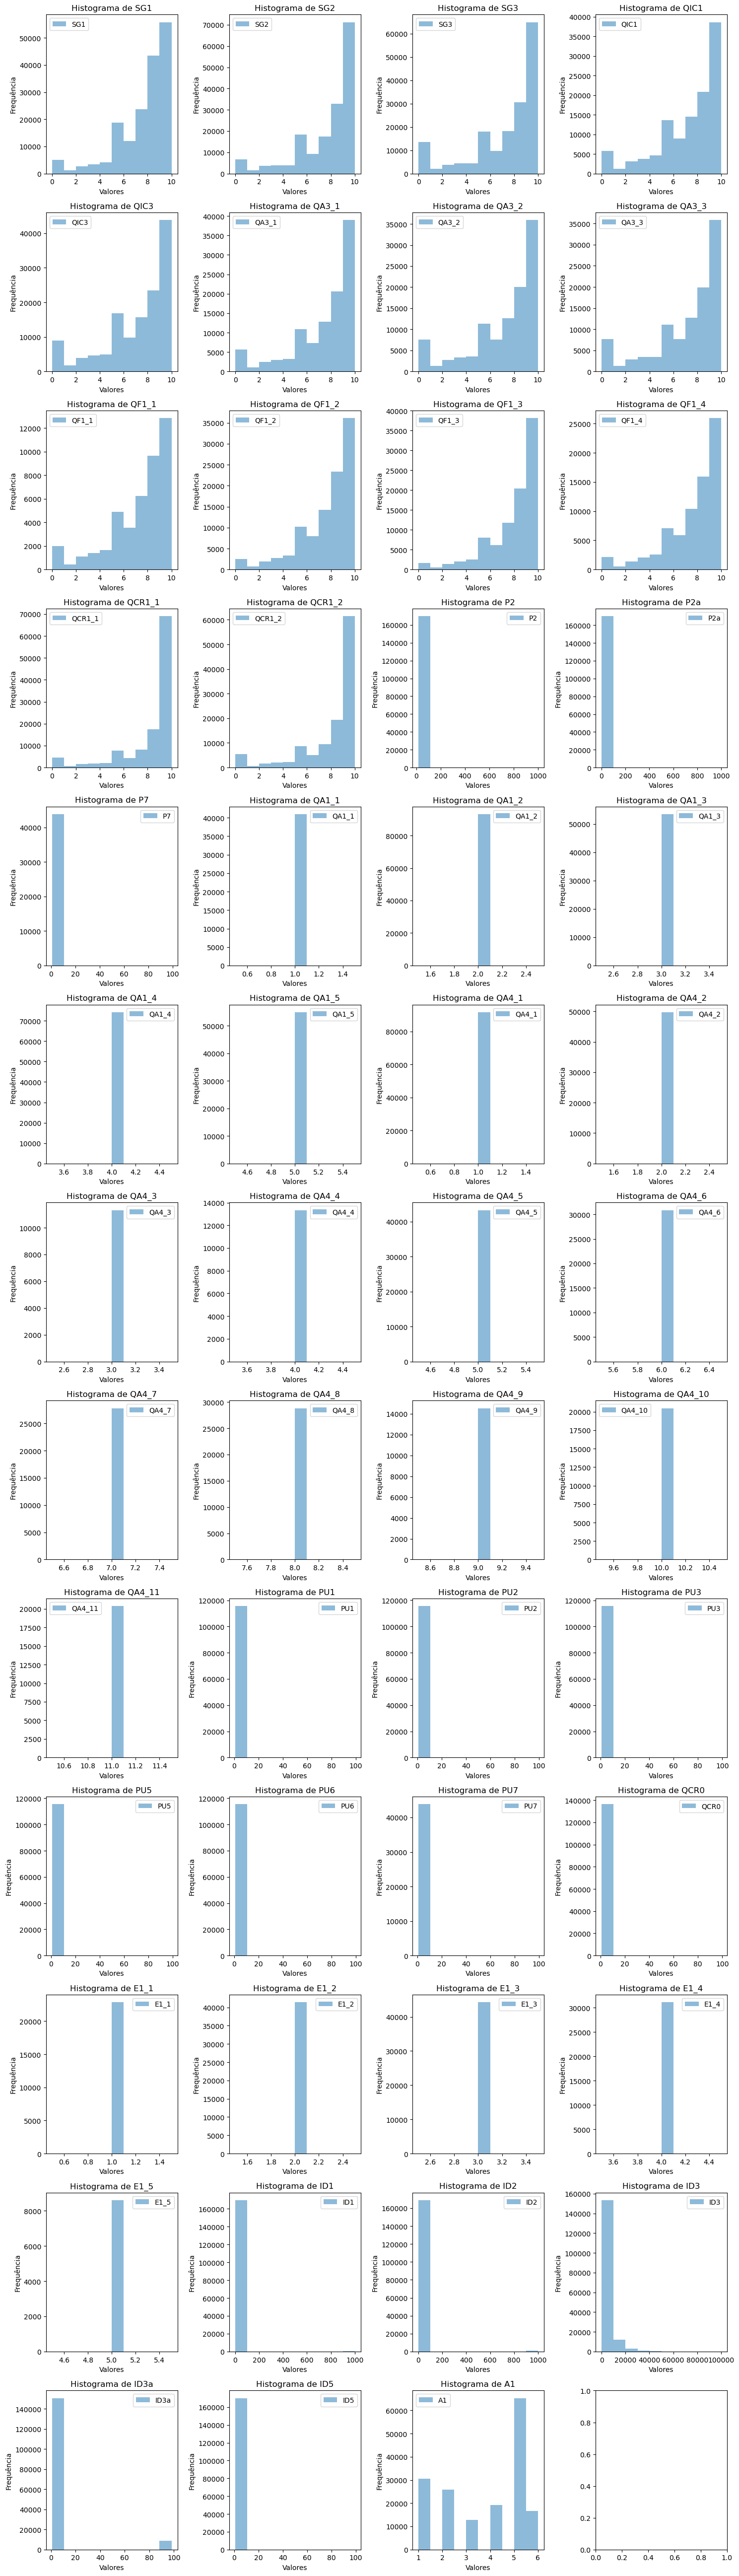

In [21]:
#Observar distribuição após limpeza de dados

colunas_selecionadas2 = bandlarg.columns[bandlarg.columns.get_loc('SG1'):]

# Definindo o número de histogramas por linha
histogramas_por_linha = 4

# Calculando o número total de linhas
num_linhas = len(colunas_selecionadas2) // histogramas_por_linha
if len(colunas_selecionadas2) % histogramas_por_linha != 0:
    num_linhas += 1

# Criando subplots com 4 histogramas por linha
fig, axs = plt.subplots(num_linhas, histogramas_por_linha, figsize=(15, 4 * num_linhas))

# Iterando sobre as colunas e plotando o histograma em subplots separados
for i, coluna in enumerate(colunas_selecionadas2):
    linha = i // histogramas_por_linha
    coluna_subplot = i % histogramas_por_linha
    
    axs[linha, coluna_subplot].hist(dados_b[coluna], bins=10, alpha=0.5, label=coluna)
    
    # Adicionando legendas e título a cada subplot
    axs[linha, coluna_subplot].set_xlabel('Valores')
    axs[linha, coluna_subplot].set_ylabel('Frequência')
    axs[linha, coluna_subplot].set_title(f'Histograma de {coluna}')
    axs[linha, coluna_subplot].legend()

# Ajustando layout
plt.tight_layout()

# Exibindo as figuras
plt.show()

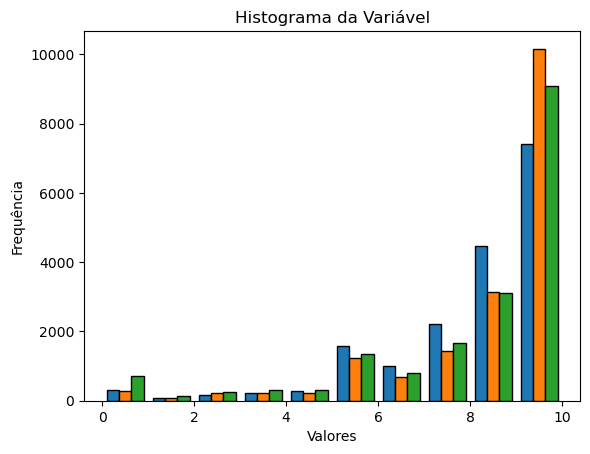

In [22]:
plt.hist(prepago[['SG1','SG2','SG3']], bins=10, edgecolor='black')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.title('Histograma da Variável')
plt.show()

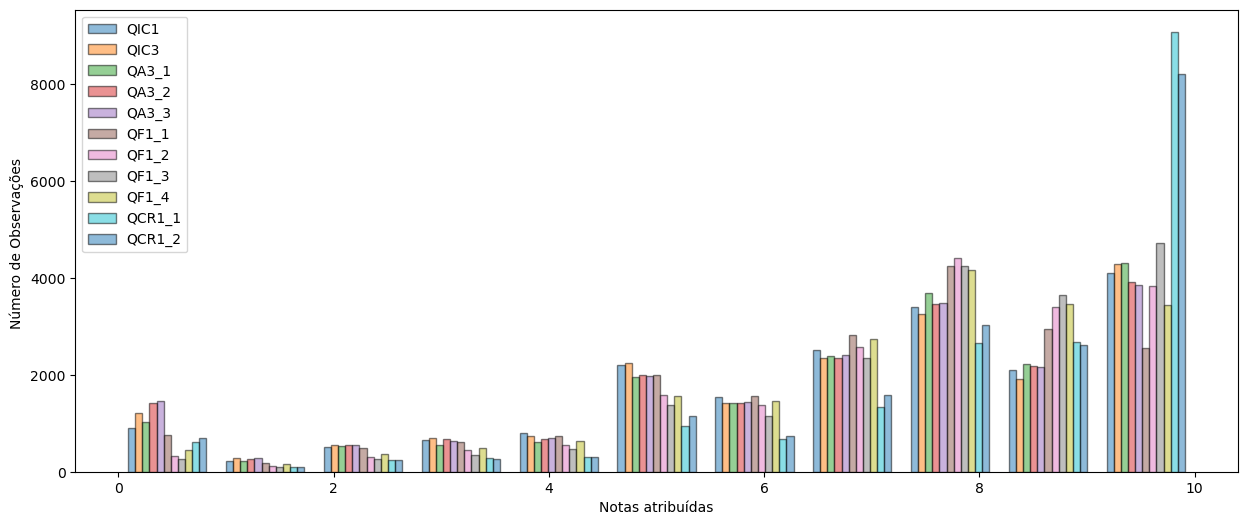

In [52]:
plt.figure(figsize=(15, 6))
plt.hist([bandlarg['QIC1'], bandlarg['QIC3'],bandlarg['QA3_1'],bandlarg['QA3_2'],bandlarg['QA3_3'],bandlarg['QF1_1'],bandlarg['QF1_2'],bandlarg['QF1_3'],bandlarg['QF1_4'],bandlarg['QCR1_1'],bandlarg['QCR1_2']], bins=11, edgecolor='black', alpha=0.5, label=['QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_1','QF1_2','QF1_3','QF1_4','QCR1_1','QCR1_2'])

plt.legend()
plt.xlabel('Notas atribuídas')
plt.ylabel('Número de Observações ')
plt.savefig('histograma_var_antes.png', dpi=1000)
plt.show()

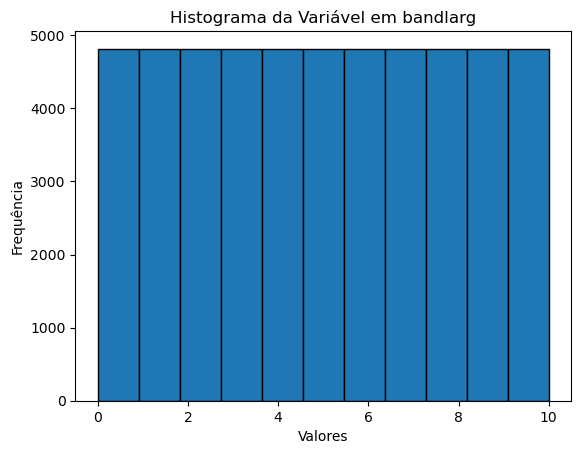

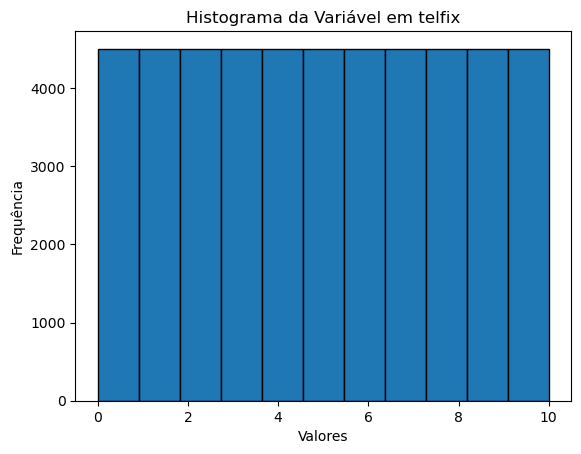

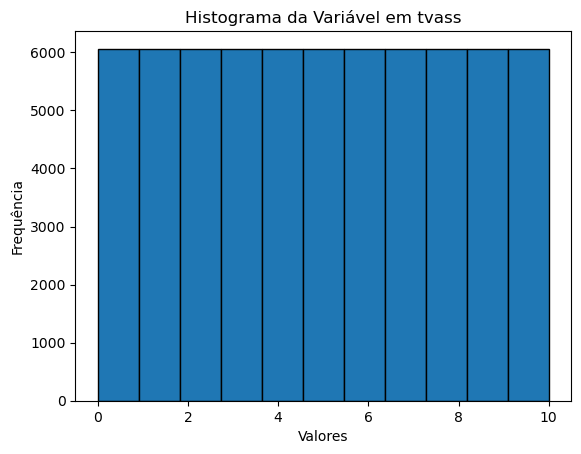

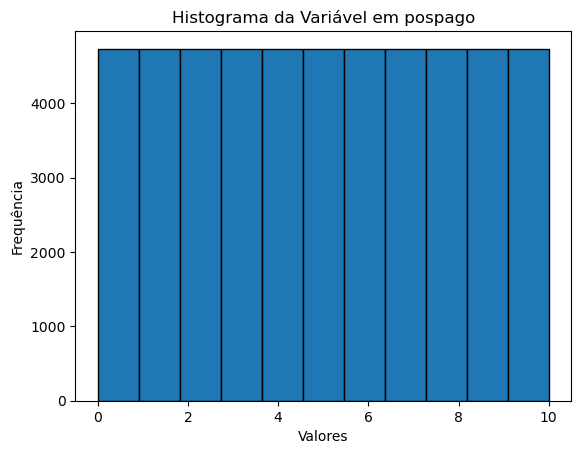

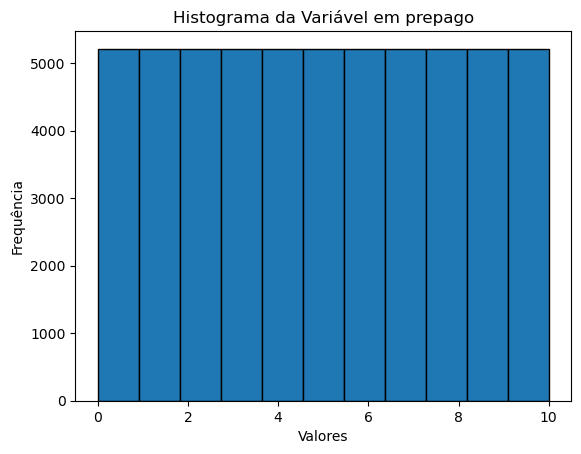

In [13]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pandas as pd

# Lista de datasets
datasets = [bandlarg, telfix, tvass, pospago, prepago]
nomes_datasets = ['bandlarg', 'telfix', 'tvass', 'pospago', 'prepago']

# Configurar a exibição para mostrar todas as colunas
pd.set_option('display.max_columns', None)

# Lista para armazenar os datasets resampleados
datasets_resampleados = []

# Iterar sobre os datasets e aplicar SMOTE
for dataset, nome_dataset in zip(datasets, nomes_datasets):
    # Separar variáveis independentes (X) e variável dependente (y)
    X = dataset.drop('SG1', axis=1)
    y = dataset['SG1']

    # Aplicar SMOTE
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Criar DataFrame com as variáveis resampleadas
    dados_resampleados = pd.DataFrame(X_resampled, columns=X.columns)

    # Adicionar a coluna 'SG1' resampleada ao DataFrame
    dados_resampleados['SG1'] = y_resampled

    # Adicionar o dataset resampleado à lista
    datasets_resampleados.append(dados_resampleados)

    # Plotar o histograma da variável 'SG1' resampleada
    plt.hist(dados_resampleados['SG1'], bins=11, edgecolor='black')
    plt.xlabel('Valores')
    plt.ylabel('Frequência')
    plt.title(f'Histograma da Variável em {nome_dataset}')
    plt.show()

# Resetar as opções de exibição para o padrão
pd.reset_option('display.max_columns')

# Exemplo de como acessar o primeiro dataset resampleado
primeiro_dataset_resampleado = datasets_resampleados[0]


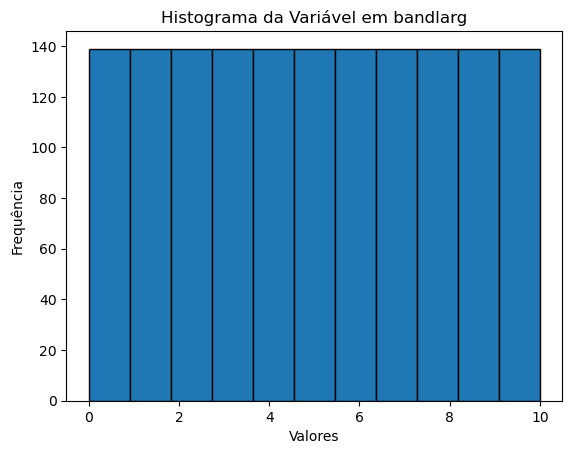

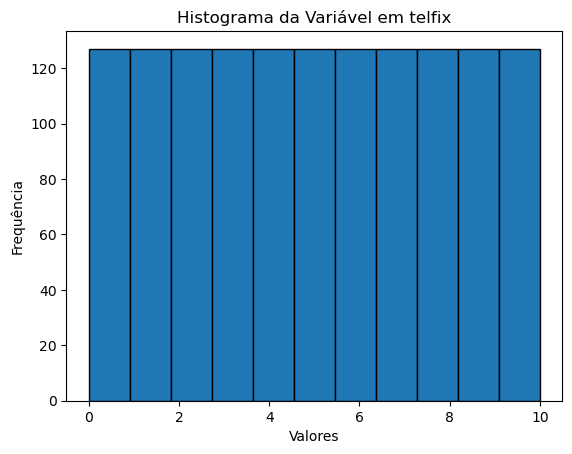

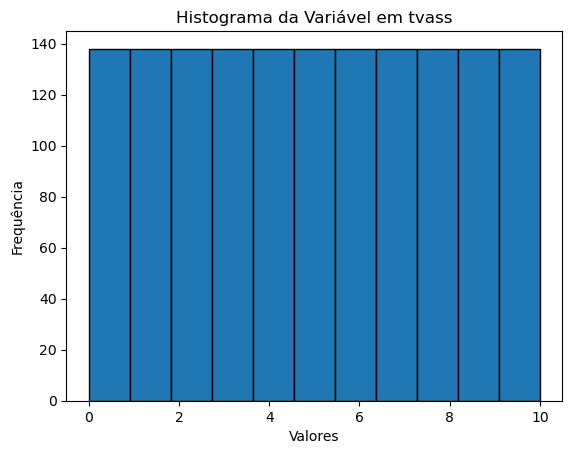

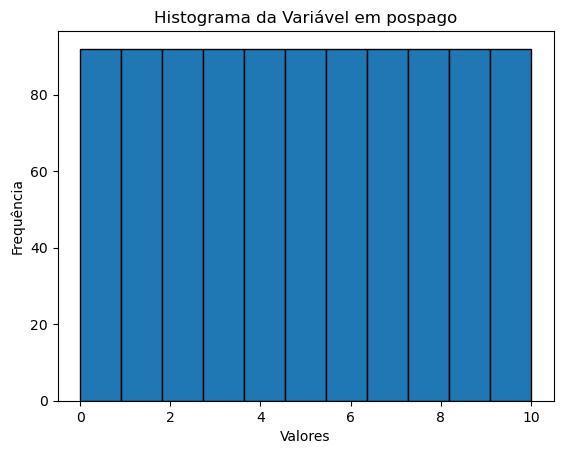

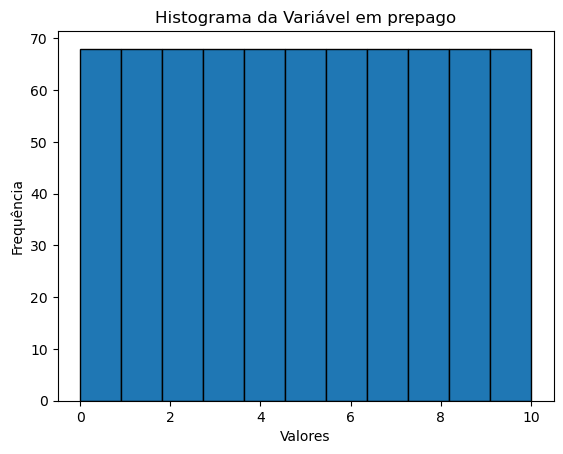

In [14]:
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import pandas as pd

# Lista de datasets
datasets = [bandlarg, telfix, tvass, pospago, prepago]
nomes_datasets = ['bandlarg', 'telfix', 'tvass', 'pospago', 'prepago']

# Configurar a exibição para mostrar todas as colunas
pd.set_option('display.max_columns', None)

# Lista para armazenar os datasets resampleados
datasets_resampleados_under = []

# Iterar sobre os datasets e aplicar RandomUnderSampler
for dataset, nome_dataset in zip(datasets, nomes_datasets):
    # Separar variáveis independentes (X) e variável dependente (y)
    X = dataset.drop('SG1', axis=1)
    y = dataset['SG1']

    # Aplicar RandomUnderSampler
    under_sampler = RandomUnderSampler()
    X_resampled, y_resampled = under_sampler.fit_resample(X, y)

    # Criar DataFrame com as variáveis resampleadas
    dados_resampleados_under = pd.DataFrame(X_resampled, columns=X.columns)

    # Adicionar a coluna 'SG1' resampleada ao DataFrame
    dados_resampleados_under['SG1'] = y_resampled

    # Adicionar o dataset resampleado à lista
    datasets_resampleados_under.append(dados_resampleados_under)

    # Plotar o histograma da variável 'SG1' resampleada
    plt.hist(dados_resampleados_under['SG1'], bins=11, edgecolor='black')
    plt.xlabel('Valores')
    plt.ylabel('Frequência')
    plt.title(f'Histograma da Variável em {nome_dataset}')
    plt.show()

# Resetar as opções de exibição para o padrão
pd.reset_option('display.max_columns')

# Exemplo de como acessar o primeiro dataset resampleado
primeiro_dataset_resampleado = datasets_resampleados[0]


In [15]:
# Exemplo de como acessar o primeiro dataset resampleado
bandlarg_res = datasets_resampleados[0]
telfix_res = datasets_resampleados[1]
tvass_res = datasets_resampleados[2]
pospago_res = datasets_resampleados[3]
prepago_res = datasets_resampleados[4]

In [16]:
# Exemplo de como acessar o primeiro dataset resampleado
bandlarg_res_under = datasets_resampleados_under[0]
telfix_res_under = datasets_resampleados_under[1]
tvass_res_under = datasets_resampleados_under[2]
pospago_res_under = datasets_resampleados_under[3]
prepago_res_under = datasets_resampleados_under[4]

In [17]:
# Lista de datasets
datasets2 = [bandlarg_res, telfix_res, tvass_res, pospago_res, prepago_res]
nomes_datasets2 = ['bandlarg_res', 'telfix_res', 'tvass_res', 'pospago_res', 'prepago_res']

# Iterar sobre os datasets e converter para tipo int
for i in range(len(datasets2)):
    # Converter todos os valores para int
    datasets2[i] = datasets2[i].astype(int)
    
    # Imprimir informações sobre o dataset convertido
    print(f"\nInformações do dataset {nomes_datasets2[i]} após a conversão:")
    print(datasets2[i].info())
    
    # Atualizar o nome do DataFrame original para o tipo inteiro
    globals()[nomes_datasets2[i]] = datasets2[i]



Informações do dataset bandlarg_res após a conversão:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52987 entries, 0 to 52986
Data columns (total 54 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   MARCA     52987 non-null  int32
 1   ESTADO    52987 non-null  int32
 2   COD_IBGE  52987 non-null  int32
 3   SG2       52987 non-null  int32
 4   SG3       52987 non-null  int32
 5   QIC1      52987 non-null  int32
 6   QIC3      52987 non-null  int32
 7   QA3_1     52987 non-null  int32
 8   QA3_2     52987 non-null  int32
 9   QA3_3     52987 non-null  int32
 10  QF1_1     52987 non-null  int32
 11  QF1_2     52987 non-null  int32
 12  QF1_3     52987 non-null  int32
 13  QF1_4     52987 non-null  int32
 14  QCR1_1    52987 non-null  int32
 15  QCR1_2    52987 non-null  int32
 16  P2        52987 non-null  int32
 17  P2a       52987 non-null  int32
 18  P7        52987 non-null  int32
 19  QA1_1     52987 non-null  int32
 20  QA1_2     52987 n

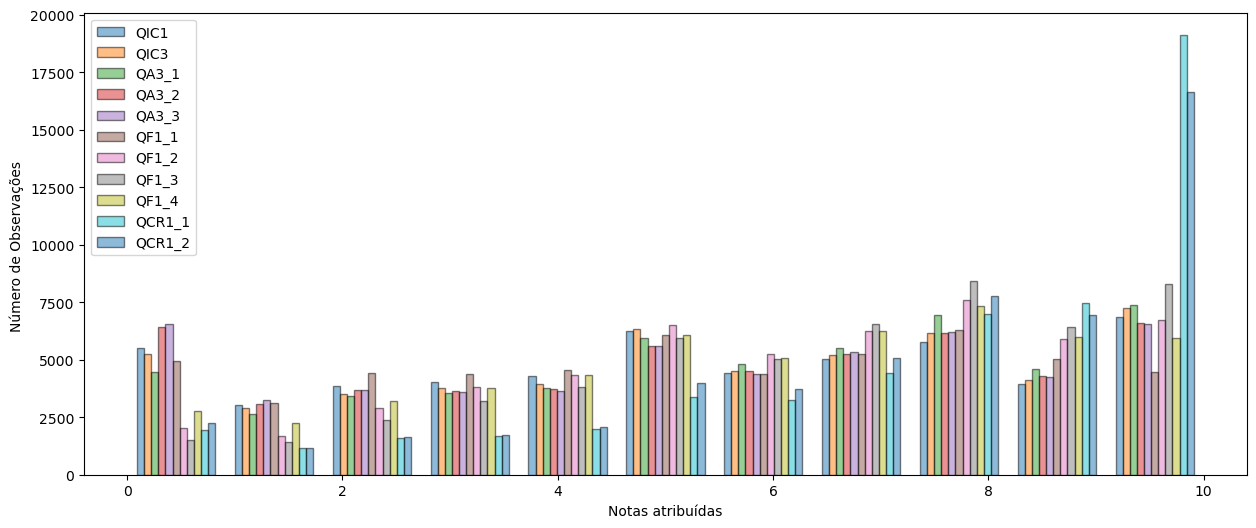

In [26]:
plt.figure(figsize=(15, 6))
plt.hist([bandlarg_res['QIC1'], bandlarg_res['QIC3'],bandlarg_res['QA3_1'],bandlarg_res['QA3_2'],bandlarg_res['QA3_3'],bandlarg_res['QF1_1'],bandlarg_res['QF1_2'],bandlarg_res['QF1_3'],bandlarg_res['QF1_4'],bandlarg_res['QCR1_1'],bandlarg_res['QCR1_2']], bins=11, edgecolor='black', alpha=0.5, label=['QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_1','QF1_2','QF1_3','QF1_4','QCR1_1','QCR1_2'])

plt.legend()
plt.xlabel('Notas atribuídas')
plt.ylabel('Número de Observações ')
plt.savefig('histograma2.png', dpi=1000)
plt.show()

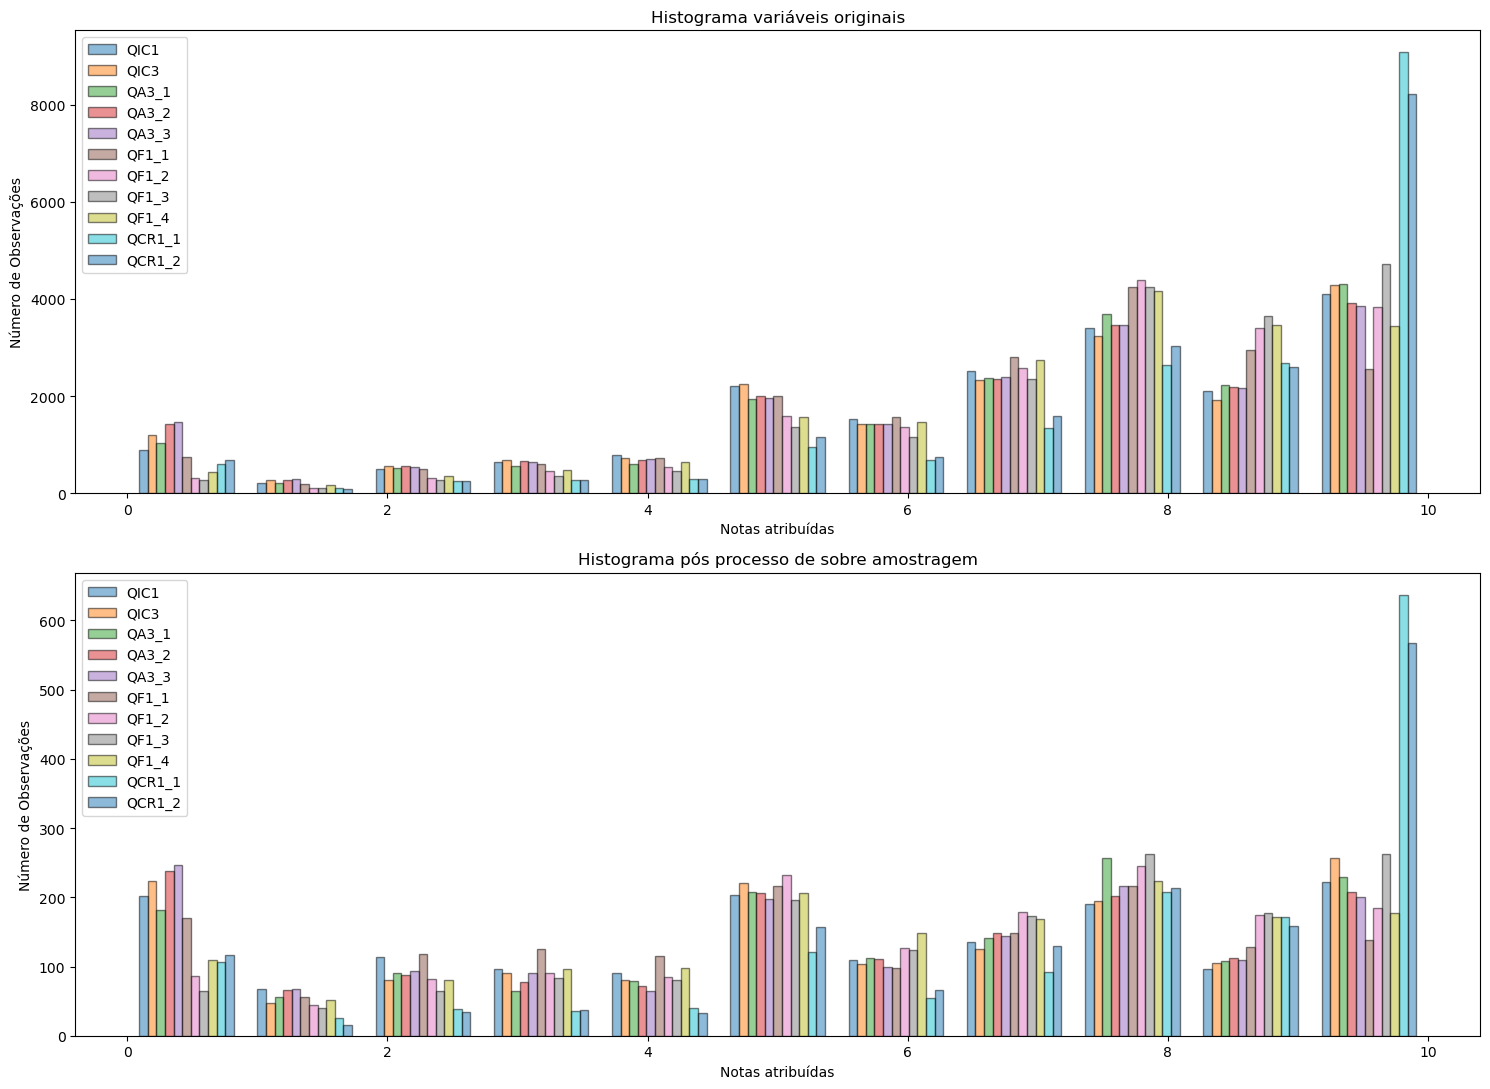

In [23]:
import matplotlib.pyplot as plt

# Crie uma nova figura
plt.figure(figsize=(15, 11))

# Plotagem do primeiro histograma
plt.subplot(2, 1, 1)  # 1 linha, 2 colunas, posição 1
plt.hist([bandlarg['QIC1'], bandlarg['QIC3'], bandlarg['QA3_1'], bandlarg['QA3_2'], bandlarg['QA3_3'], bandlarg['QF1_1'], bandlarg['QF1_2'], bandlarg['QF1_3'], bandlarg['QF1_4'], bandlarg['QCR1_1'], bandlarg['QCR1_2']], bins=11, edgecolor='black', alpha=0.5, label=['QIC1', 'QIC3', 'QA3_1', 'QA3_2', 'QA3_3', 'QF1_1', 'QF1_2', 'QF1_3', 'QF1_4', 'QCR1_1', 'QCR1_2'])
plt.legend()
plt.xlabel('Notas atribuídas')
plt.ylabel('Número de Observações')
plt.title('Histograma variáveis originais')

# Plotagem do segundo histograma
plt.subplot(2, 1, 2)  # 1 linha, 2 colunas, posição 2
plt.hist([bandlarg_res['QIC1'], bandlarg_res['QIC3'], bandlarg_res['QA3_1'], bandlarg_res['QA3_2'], bandlarg_res['QA3_3'], bandlarg_res['QF1_1'], bandlarg_res['QF1_2'], bandlarg_res['QF1_3'], bandlarg_res['QF1_4'], bandlarg_res['QCR1_1'], bandlarg_res['QCR1_2']], bins=11, edgecolor='black', alpha=0.5, label=['QIC1', 'QIC3', 'QA3_1', 'QA3_2', 'QA3_3', 'QF1_1', 'QF1_2', 'QF1_3', 'QF1_4', 'QCR1_1', 'QCR1_2'])
plt.legend()
plt.xlabel('Notas atribuídas')
plt.ylabel('Número de Observações')
plt.title('Histograma pós processo de sobre amostragem')

# Salve a figura
plt.savefig('histograma_combined.png', dpi=1000)

# Exiba a figura
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de texto
plt.show()


In [ ]:
# Dataset telfix_res
plt.figure(figsize=(11, 6))
plt.hist([telfix_res['SG2'], telfix_res['SG3'], telfix_res['QIC3'], telfix_res['QF1_4'], telfix_res['QCR1_1'], telfix_res['QCR1_2'], telfix_res['QF2_1'], telfix_res['QF2_2'], telfix_res['QF2_3']], bins=10, edgecolor='black', alpha=0.5, label=['SG2', 'SG3', 'QIC3', 'QCR1_1', 'QCR1_2','QF2_1','QF2_2','QF2_3'])
plt.legend()
plt.xlabel('Notas atribuídas')
plt.ylabel('Número de Observações ')
#plt.savefig('histograma_telfix_res.png', dpi=800)
plt.show()

# Dataset tvass_res
plt.figure(figsize=(11, 6))
plt.hist([tvass_res['SG2'], tvass_res['SG3'], tvass_res['QIC3'], tvass_res['QCR1_1'], tvass_res['QCR1_2']], bins=10, edgecolor='black', alpha=0.5, label=['SG2', 'SG3', 'QIC1', 'QIC3', 'QA3_1', 'QA3_2', 'QA3_3', 'QF1_1', 'QF1_2', 'QF1_3', 'QF1_4', 'QCR1_1', 'QCR1_2'])
plt.legend()
plt.xlabel('Notas atribuídas')
plt.ylabel('Número de Observações ')
#plt.savefig('histograma_tvass_res.png', dpi=800)
plt.show()

# Dataset pospago_res
plt.figure(figsize=(11, 6))
plt.hist([pospago_res['SG2'], pospago_res['SG3'], pospago_res['QIC1'], pospago_res['QIC3'], pospago_res['QA3_1'], pospago_res['QA3_2'], pospago_res['QA3_3'], pospago_res['QF1_1'], pospago_res['QF1_2'], pospago_res['QF1_3'], pospago_res['QF1_4'], pospago_res['QCR1_1'], pospago_res['QCR1_2']], bins=10, edgecolor='black', alpha=0.5, label=['SG2', 'SG3', 'QIC1', 'QIC3', 'QA3_1', 'QA3_2', 'QA3_3', 'QF1_1', 'QF1_2', 'QF1_3', 'QF1_4', 'QCR1_1', 'QCR1_2'])
plt.legend()
plt.xlabel('Notas atribuídas')
plt.ylabel('Número de Observações ')
#plt.savefig('histograma_pospago_res.png', dpi=800)
plt.show()

# Dataset prepago_res
plt.figure(figsize=(11, 6))
plt.hist([prepago_res['SG2'], prepago_res['SG3'], prepago_res['QIC1'], prepago_res['QIC3'], prepago_res['QA3_1'], prepago_res['QA3_2'], prepago_res['QA3_3'], prepago_res['QF1_1'], prepago_res['QF1_2'], prepago_res['QF1_3'], prepago_res['QF1_4'], prepago_res['QCR1_1'], prepago_res['QCR1_2']], bins=10, edgecolor='black', alpha=0.5, label=['SG2', 'SG3', 'QIC1', 'QIC3', 'QA3_1', 'QA3_2', 'QA3_3', 'QF1_1', 'QF1_2', 'QF1_3', 'QF1_4', 'QCR1_1', 'QCR1_2'])
plt.legend()
plt.xlabel('Notas atribuídas')
plt.ylabel('Número de Observações ')
#plt.savefig('histograma_prepago_res.png', dpi=800)
plt.show()


In [19]:
print("Número de linhas após a limpeza:")
print("bandlarg:", bandlarg_res.shape[0])
print("telfix:", telfix_res.shape[0])
print("tvass:", tvass_res.shape[0])
print("pospago:", pospago_res.shape[0])
print("prepago:", prepago_res.shape[0])

Número de linhas após a limpeza:
bandlarg: 1529
telfix: 1397
tvass: 1518
pospago: 1012
prepago: 748


In [28]:
pd.set_option('display.max_columns', None)
descri4=dados_resampleados.describe()
print(descri4)
pd.reset_option('display.max_columns')

                SG2           SG3          QIC1          QIC2         QF1_2  \
count  57343.000000  57343.000000  57343.000000  57343.000000  57343.000000   
mean       6.022539      5.091761      5.509247      6.125757      6.001169   
std        3.103566      3.530908      3.055093      2.995907      2.682074   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.630246      1.609187      3.013176      3.973730      4.062320   
50%        6.255346      5.000000      5.661666      6.519041      6.060932   
75%        9.000000      8.000000      8.000000      8.883307      8.000000   
max       10.000000     10.000000     10.000000     10.000000     10.000000   

              QF1_3         QF1_5         QF2_1        QCR2_1        QCR2_2  \
count  57343.000000  57343.000000  57343.000000  57343.000000  57343.000000   
mean       6.273821      5.618945      6.881013      6.768684      6.460316   
std        2.728224      2.776253      2.548409    

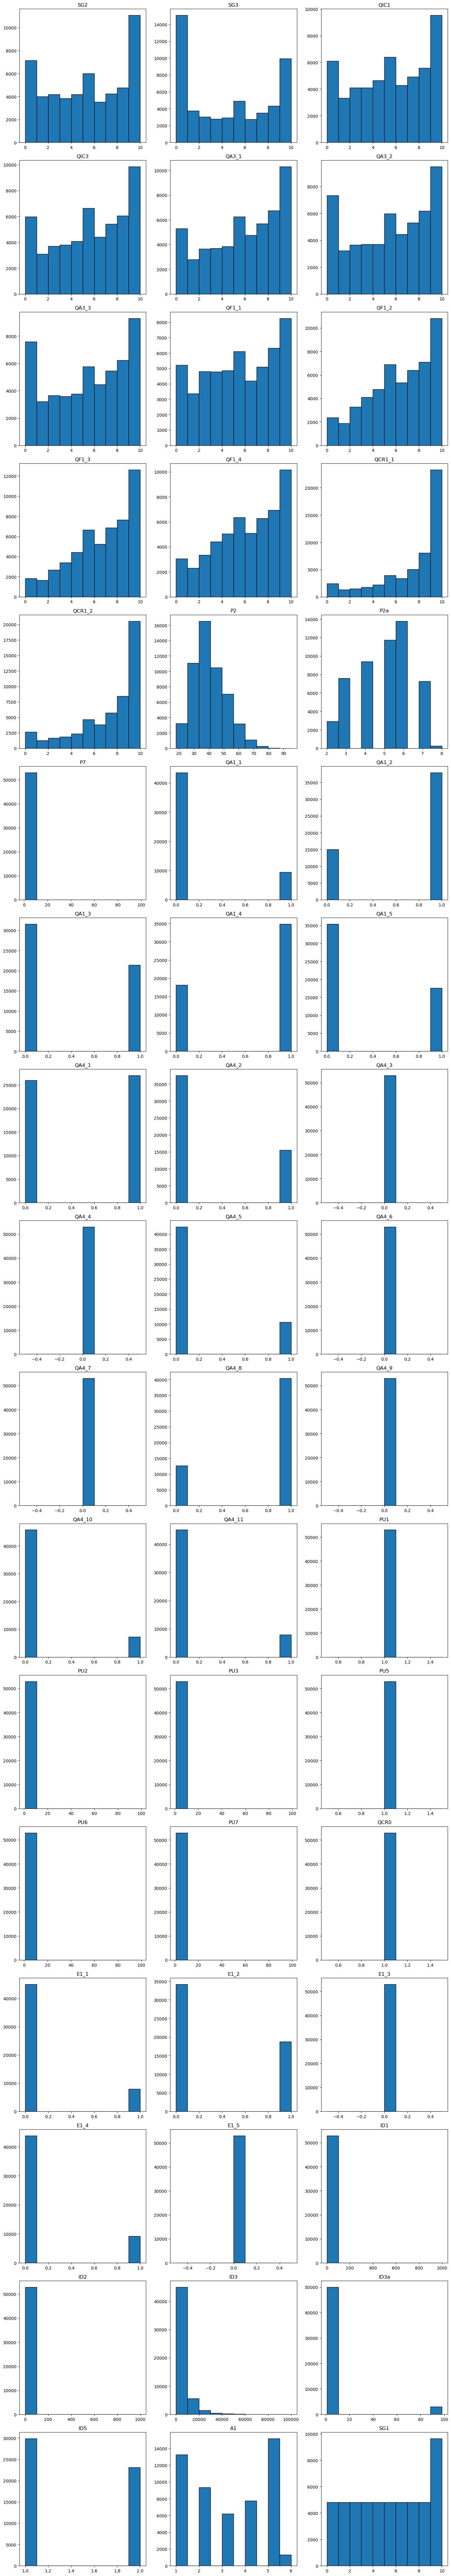

In [97]:
num_variaveis = len(bandlarg_res.columns)
num_linhas = (num_variaveis - 1) // 3 + 1  # 3 colunas por linha
num_colunas = min(3, num_variaveis)  # Máximo de 3 colunas

# Configurar opção para exibir todos os histogramas em uma única figura
plt.figure(figsize=(15, 5 * num_linhas))

# Iterar sobre todas as colunas do DataFrame e plotar histograma para cada uma
for i, column in enumerate(bandlarg_res.columns):
    plt.subplot(num_linhas, num_colunas, i + 1)
    plt.hist(bandlarg_res[column], bins=10, edgecolor='black')
    plt.title(column)

# Ajustar layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exibir a figura
plt.show()

In [ ]:
#Renomear colunas

#dados_b_limpo.rename(columns = {'P2': 'Idade'}, inplace=True)
#dados_b_limpo.rename(columns = {'P2a': 'Faixa_etaria'}, inplace=True)
#dados_b_limpo.rename(columns = {'P4': 'Faixa_tempo_assinatura'}, inplace=True)
#dados_b_limpo.rename(columns = {'P6': 'Tipo_servico'}, inplace=True)
#dados_b_limpo.rename(columns = {'P7': 'Fibra_otica'}, inplace=True)
#dados_b_limpo.rename(columns = {'SG1': 'Nivel_satisfacao'}, inplace=True)
#dados_b_limpo.rename(columns = {'SG2': 'Nivel_continuar'}, inplace=True)
#dados_b_limpo.rename(columns = {'SG3': 'Nivel_recomendar'}, inplace=True)
#dados_b_limpo.rename(columns = {'QIC1': 'Cobertura_sinal'}, inplace=True)
#dados_b_limpo.rename(columns = {'QA1': 'Canal_atendimento'}, inplace=True)
#dados_b_limpo.rename(columns = {'QA2_1': 'Clareza_atendimento'}, inplace=True)
#dados_b_limpo.rename(columns = {'QA2_2': 'Facilidade_atendimento'}, inplace=True)
#dados_b_limpo.rename(columns = {'QA2_3': 'Velocidade_atendimento'}, inplace=True)
#dados_b_limpo.head()

# Árvore de decisão

In [23]:
#Criando dataframe
df1 = pd.DataFrame(bandlarg)
df2 = pd.DataFrame(telfix)
df3 = pd.DataFrame(tvass)
df4 = pd.DataFrame(pospago)
df5 = pd.DataFrame(prepago)

# Separar as features e o target
X1 = df1[['MARCA','ESTADO','QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_1','QF1_2','QF1_3','QF1_4','QCR1_1','QCR1_2','P2','P2a','P7','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','PU7','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y1 = df1['SG1']

X2 = df2[['MARCA','ESTADO','QIC3','QF2_1','QF2_2','QF2_3','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y2 = df2['SG1']

X3 = df3[['MARCA','ESTADO','QIC3','QF3_1','QF3_2','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y3 = df3['SG1']

X4 = df4[['MARCA','ESTADO','QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_2','QF1_3','QF1_5','QF2_1','QCR1_1','QCR1_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y4 = df4['SG1']

X5 = df5[['MARCA','ESTADO','QIC1','QIC2','QF1_2','QF1_3','QF1_5','QF2_1','QCR2_1','QCR2_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y5 = df5['SG1']



# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Crie o modelo de árvore de decisão
model = tree.DecisionTreeClassifier(criterion='entropy')

# Treine o modelo
model.fit(X_train, y_train)

# Faça previsões no conjunto de teste
predictions = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, predictions)


# Avalie a precisão do modelo
accuracy = accuracy_score(y_test, predictions)
print(f'Acurácia do modelo: {accuracy}')
print("Matriz de Confusão:")
print(conf_matrix)

Acurácia do modelo: 0.3224101479915433
Matriz de Confusão:
[[ 33   4   7   6  12  22   7   7   2   2   3]
 [  7   5   5   4   5   6   4   1   1   0   2]
 [ 17   2   3   3   7   9   6   7   3   2   2]
 [  6   2   9  11   8  27  15  10   7   5   2]
 [  9   2   5  15  14  40  18  17   9   2   1]
 [ 10   3  10  23  30 119  53  64  58  16   9]
 [  8   2   6   8  17  74  64  74  63  10  11]
 [  5   0   3  10  14  61  77 169 194  43  33]
 [  5   1   3   4  13  43  65 178 378 154 112]
 [  1   0   1   2   3  16  10  39 172 133 108]
 [  2   2   1   1   0  11  15  25 122  92 291]]


In [24]:
#Criando dataframe
df1 = pd.DataFrame(bandlarg_res)
df2 = pd.DataFrame(telfix_res)
df3 = pd.DataFrame(tvass_res)
df4 = pd.DataFrame(pospago_res)
df5 = pd.DataFrame(prepago_res)

# Separar as features e o target
X1 = df1[['QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_1','QF1_2','QF1_3','QF1_4','QCR1_1','QCR1_2','P2','P2a','P7','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','PU7','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y1 = df1['SG2']

X2 = df2[['QIC3','QF2_1','QF2_2','QF2_3','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y2 = df2['SG3']

X3 = df3[['QIC3','QF3_1','QF3_2','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y3 = df3['SG3']

X4 = df4[['QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_2','QF1_3','QF1_5','QF2_1','QCR1_1','QCR1_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y4 = df4['SG3']

X5 = df5[['QIC1','QIC2','QF1_2','QF1_3','QF1_5','QF2_1','QCR2_1','QCR2_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y5 = df5['SG3']



# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Crie o modelo de árvore de decisão
model = tree.DecisionTreeClassifier(criterion='entropy')

# Treine o modelo
model.fit(X_train, y_train)

# Faça previsões no conjunto de teste
predictions = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, predictions)


# Avalie a precisão do modelo
accuracy = accuracy_score(y_test, predictions)
print(f'Acurácia do modelo: {accuracy}')
print("Matriz de Confusão:")
print(conf_matrix)

Acurácia do modelo: 0.5068880920928477
Matriz de Confusão:
[[1083   89   43   48   40   63   14   17    7   15    5]
 [  97  530   60   34   26   29    8    7    6    0    3]
 [  47   79  494   66   32   43   28    8   12    2    3]
 [  42   35   94  435   93   50   20   28   10    5    4]
 [  42   22   39   93  433  106   26   20   27   13    3]
 [  55   40   44   71  129  480  138  107   70   32   22]
 [  25   13   21   20   45  103  235  122   63   21   25]
 [  16   15   14   25   36  103  114  272  163   70   53]
 [   5    1   10   18   23   78   72  175  272  178  134]
 [   3    1    4    7   10   34   32   85  164  361  222]
 [   8    1    6    6   10   40   22   48  145  206  777]]


In [53]:
print(bandlarg_res['SG1'].info)

<bound method Series.info of 0         6.0
1         8.0
2        10.0
3         6.0
4         8.0
         ... 
52982    10.0
52983    10.0
52984    10.0
52985    10.0
52986    10.0
Name: SG1, Length: 52987, dtype: float64>


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

# Função para treinar e avaliar o modelo
def treinar_avaliar_modelo(X, y, nome_dataset):
    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Criar o modelo de árvore de decisão
    model = DecisionTreeClassifier(criterion='entropy')

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Faça previsões no conjunto de teste
    predictions = model.predict(X_test)

    # Imprimir a matriz de confusão
    conf_matrix = confusion_matrix(y_test, predictions)
    
    # Criar um DataFrame para a matriz de confusão com nomes de variáveis e colunas
    conf_matrix_df = pd.DataFrame(conf_matrix, index=[f'Actual {classe}' for classe in model.classes_], 
                                  columns=[f'Predicted {classe}' for classe in model.classes_])
    
    print(f'\nMatriz de Confusão para {nome_dataset}:\n{conf_matrix_df}')

    # Avaliar a precisão do modelo
    accuracy = accuracy_score(y_test, predictions)
    print(f'Acurácia do modelo para {nome_dataset}: {accuracy}')

# Criar dataframes para cada dataset
df1 = pd.DataFrame(bandlarg)
df2 = pd.DataFrame(telfix)
df3 = pd.DataFrame(tvass)
df4 = pd.DataFrame(pospago)
df5 = pd.DataFrame(prepago)

# Separar features e target para cada dataset
X1 = df1[['QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_1','QF1_2','QF1_3','QF1_4','QCR1_1','QCR1_2','P2','P2a','P7','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','PU7','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y1 = df1['SG1']

X2 = df2[['QIC3','QF2_1','QF2_2','QF2_3','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y2 = df2['SG1']

X3 = df3[['QIC3','QF3_1','QF3_2','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y3 = df3['SG1']

X4 = df4[['QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_2','QF1_3','QF1_5','QF2_1','QCR1_1','QCR1_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y4 = df4['SG1']

X5 = df5[['QIC1','QIC2','QF1_2','QF1_3','QF1_5','QF2_1','QCR2_1','QCR2_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y5 = df5['SG1']

# Treinar e avaliar o modelo para cada dataset
#treinar_avaliar_modelo(X1, y1, 'df1')
#treinar_avaliar_modelo(X2, y2, 'df2')
#treinar_avaliar_modelo(X3, y3, 'df3')
#treinar_avaliar_modelo(X4, y4, 'df4')
#treinar_avaliar_modelo(X5, y5, 'df5')

# Resetar as opções de exibição para o padrão
pd.reset_option('display.max_columns')

## Matriz confusão original

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

# Função para treinar e avaliar o modelo
def treinar_avaliar_modelo(X, y, nome_dataset):
    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Criar o modelo de árvore de decisão
    model = DecisionTreeClassifier(criterion='entropy')

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Faça previsões no conjunto de teste
    predictions = model.predict(X_test)

    # Imprimir a matriz de confusão
    conf_matrix = confusion_matrix(y_test, predictions)
    print(f'\nMatriz de Confusão para {nome_dataset}:\n{conf_matrix}')

    # Avaliar a precisão do modelo
    accuracy = accuracy_score(y_test, predictions)
    print(f'Acurácia do modelo para {nome_dataset}: {accuracy}')

# Criar dataframes para cada dataset
df1 = pd.DataFrame(bandlarg)
df2 = pd.DataFrame(telfix)
df3 = pd.DataFrame(tvass)
df4 = pd.DataFrame(pospago)
df5 = pd.DataFrame(prepago)

# Separar features e target para cada dataset
X1 = df1[['MARCA','ESTADO','QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_1','QF1_2','QF1_3','QF1_4','QCR1_1','QCR1_2','P2','P2a','P7','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','PU7','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y1 = df1['SG1']

X2 = df2[['MARCA','ESTADO','QIC3','QF2_1','QF2_2','QF2_3','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y2 = df2['SG1']

X3 = df3[['MARCA','ESTADO','QIC3','QF3_1','QF3_2','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y3 = df3['SG1']

X4 = df4[['MARCA','ESTADO','QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_2','QF1_3','QF1_5','QF2_1','QCR1_1','QCR1_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y4 = df4['SG1']

X5 = df5[['MARCA','ESTADO','QIC1','QIC2','QF1_2','QF1_3','QF1_5','QF2_1','QCR2_1','QCR2_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
y5 = df5['SG1']

# Treinar e avaliar o modelo para cada dataset
treinar_avaliar_modelo(X1, y1, 'df1')
treinar_avaliar_modelo(X2, y2, 'df2')
treinar_avaliar_modelo(X3, y3, 'df3')
treinar_avaliar_modelo(X4, y4, 'df4')
treinar_avaliar_modelo(X5, y5, 'df5')

# Resetar as opções de exibição para o padrão
pd.reset_option('display.max_columns')




Matriz de Confusão para df1:
[[ 28   6   9   8  10  22   5   6   4   2   5]
 [  5   7   3   4   4   7   6   1   1   0   2]
 [ 16   3   6   3   7  10   6   3   1   2   4]
 [ 10   4   8  12   8  24  15  15   3   1   2]
 [  7   2   5  14  14  44  16  18   9   3   0]
 [ 14   5  12  23  30 113  65  60  49  14  10]
 [  8   2   6  10  16  74  60  72  66  10  13]
 [  5   0   4   9  11  58  77 166 212  34  33]
 [  2   0   3   6  13  43  72 183 359 160 115]
 [  1   0   0   1   3  13  10  47 174 129 107]
 [  2   2   2   2   1   8  16  31 114  75 309]]
Acurácia do modelo para df1: 0.3179175475687104

Matriz de Confusão para df2:
[[ 37   3  15   4   4  23   5   9  13   4   6]
 [  1   3   1   1   1   6   1   2   4   0   5]
 [  9   3   3   5   4  12   6   4   8   2   1]
 [  8   0   4   4   8  23   6   3  15   3   5]
 [  8   1   8   4   6  11   6  14  18   4   8]
 [ 16   4  10  11  15 111  44  55  87  19  36]
 [  7   0   1  12   5  39  29  43  47  13  17]
 [  8   4  11   4  10  74  50  79 134  47  51

## Matriz de confusão resempleado

In [20]:
# Função para treinar e avaliar o modelo
def treinar_avaliar_modelo(X, y, nome_dataset):
    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Criar o modelo de árvore de decisão
    model = DecisionTreeClassifier(criterion='entropy')

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Faça previsões no conjunto de teste
    predictions = model.predict(X_test)

    # Imprimir a matriz de confusão
    conf_matrix = confusion_matrix(y_test, predictions)
    print(f'\nMatriz de Confusão para {nome_dataset}:\n{conf_matrix}')

    # Avaliar a precisão do modelo
    accuracy = accuracy_score(y_test, predictions)
    print(f'Acurácia do modelo para {nome_dataset}: {accuracy}')

# Criar dataframes para cada dataset
df1 = pd.DataFrame(bandlarg_res)
df2 = pd.DataFrame(telfix_res)
df3 = pd.DataFrame(tvass_res)
df4 = pd.DataFrame(pospago_res)
df5 = pd.DataFrame(prepago_res)

#Resempleado Under

df6 = pd.DataFrame(bandlarg_res_under)
df7 = pd.DataFrame(telfix_res_under)
df8 = pd.DataFrame(tvass_res_under)
df9 = pd.DataFrame(pospago_res_under)
df10 = pd.DataFrame(prepago_res_under)

X1 = df1[['MARCA','ESTADO','QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_1','QF1_2','QF1_3','QF1_4','QCR1_1','QCR1_2','P2','P2a','P7','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','PU7','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X2 = df2[['MARCA','ESTADO','QIC3','QF2_1','QF2_2','QF2_3','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X3 = df3[['MARCA','ESTADO','QIC3','QF3_1','QF3_2','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X4 = df4[['MARCA','ESTADO','QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_2','QF1_3','QF1_5','QF2_1','QCR1_1','QCR1_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X5 = df5[['MARCA','ESTADO','QIC1','QIC2','QF1_2','QF1_3','QF1_5','QF2_1','QCR2_1','QCR2_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]


X6 = df6[['MARCA','ESTADO','QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_1','QF1_2','QF1_3','QF1_4','QCR1_1','QCR1_2','P2','P2a','P7','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','PU7','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X7 = df7[['MARCA','ESTADO','QIC3','QF2_1','QF2_2','QF2_3','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X8 = df8[['MARCA','ESTADO','QIC3','QF3_1','QF3_2','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X9 = df9[['MARCA','ESTADO','QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_2','QF1_3','QF1_5','QF2_1','QCR1_1','QCR1_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X10 = df10[['MARCA','ESTADO','QIC1','QIC2','QF1_2','QF1_3','QF1_5','QF2_1','QCR2_1','QCR2_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]


In [21]:
#Análise variável SG1
# Definir variável target
y1 = df1['SG1']
y2 = df2['SG1']
y3 = df3['SG1']
y4 = df4['SG1']
y5 = df5['SG1']


# Treinar e avaliar o modelo para cada dataset
treinar_avaliar_modelo(X1, y1, 'df1')
treinar_avaliar_modelo(X2, y2, 'df2')
treinar_avaliar_modelo(X3, y3, 'df3')
treinar_avaliar_modelo(X4, y4, 'df4')
treinar_avaliar_modelo(X5, y5, 'df5')


Matriz de Confusão para df1:
[[673  36  53  54  49  50  21  12   7   4   5]
 [ 23 812  16  17  23   8   3   3   2   0   3]
 [ 63  35 757  44  41  38  26   9   7   4   2]
 [ 50  29  59 637  61  59  41  19  11   3   5]
 [ 42  22  52  77 576  82  53  31   4   5   5]
 [ 58  16  49  71  94 335 164  94  41  25  13]
 [ 21  13  31  46  62 131 384 165  58  42  13]
 [ 13   5  15  14  48 106 143 318 213  80  33]
 [  5   0   6   7   9  64  51 182 376 167 121]
 [  1   2   2   5   4  24  35  89 152 472 170]
 [  4   1   2   1   5  14  20  41 100 177 552]]
Acurácia do modelo para df1: 0.5559539535761464

Matriz de Confusão para df2:
[[548  18  69  51  49  53  36  30  12  14  10]
 [ 24 725  24  23  13  29  14  12   4   3   1]
 [ 57  31 656  41  32  40  30  30   3  12   4]
 [ 49  34  71 604  54  49  46  24  10   9   6]
 [ 31  24  40  65 554  62  58  38  14  11   5]
 [ 49  30  57  58  76 232 118  83  82  55  47]
 [ 33  14  36  57  48  91 370 109  59  59  15]
 [ 29  15  26  33  46  99 110 250 146 100  59

In [25]:
#Análise variável SG2
# Definir variável target
y1 = df1['SG2']
y2 = df2['SG2']
y3 = df3['SG2']
y4 = df4['SG2']
y5 = df5['SG2']


# Treinar e avaliar o modelo para cada dataset
treinar_avaliar_modelo(X1, y1, 'df1')
treinar_avaliar_modelo(X2, y2, 'df2')
treinar_avaliar_modelo(X3, y3, 'df3')
treinar_avaliar_modelo(X4, y4, 'df4')
treinar_avaliar_modelo(X5, y5, 'df5')


Matriz de Confusão para df1:
[[10  4  7  4  1  6  3  5  2  2  0]
 [ 3  1  1  1  1  1  2  0  0  0  0]
 [ 7  4  4  5  2  0  0  1  1  0  1]
 [ 6  2  3  3  1  4  2  1  3  0  0]
 [ 1  2  1  3  1  1  1  4  0  0  0]
 [ 6  4  3  6  3  5  7  3  1  1  4]
 [ 2  0  0  0  0  1  2  2  2  1  2]
 [ 1  1  2  1  4  3  3  4  5  3  6]
 [ 0  0  3  1  0  3  3  7  6  4 11]
 [ 1  0  1  1  1  3  1  0  2  6 12]
 [ 0  0  1  2  0  1  0  2  6  6 16]]
Acurácia do modelo para df1: 0.1895424836601307

Matriz de Confusão para df2:
[[ 6  2  1  1  0 10  3  0  1  2  3]
 [ 3  2  0  0  1  4  2  0  0  1  0]
 [ 0  2  4  2  5  2  2  1  3  1  3]
 [ 1  2  1  4  2  3  4  2  1  0  0]
 [ 0  1  3  1  3  0  0  4  2  1  3]
 [ 6  4  3  3  4  6  4  5  3  2  6]
 [ 1  1  1  2  0  1  1  3  1  0  1]
 [ 0  0  2  2  0  6  2  2  1  2  1]
 [ 3  0  2  0  3  9  1  1  4  6  6]
 [ 1  0  0  0  0  4  1  1  8  3  5]
 [ 1  1  1  1  2  5  0  0  3 12 15]]
Acurácia do modelo para df2: 0.17857142857142858

Matriz de Confusão para df3:
[[12  4  6  9  4  3

In [26]:
#Análise variável SG3
# Definir variável target
y1 = df1['SG3']
y2 = df2['SG3']
y3 = df3['SG3']
y4 = df4['SG3']
y5 = df5['SG3']


# Treinar e avaliar o modelo para cada dataset
treinar_avaliar_modelo(X1, y1, 'df1')
treinar_avaliar_modelo(X2, y2, 'df2')
treinar_avaliar_modelo(X3, y3, 'df3')
treinar_avaliar_modelo(X4, y4, 'df4')
treinar_avaliar_modelo(X5, y5, 'df5')


Matriz de Confusão para df1:
[[50  7  5  4  1  9  1  5  3  2  1]
 [ 4  2  2  1  0  1  3  1  0  0  0]
 [ 4  0  2  1  2  3  1  1  0  0  0]
 [ 6  2  1  1  1  1  2  1  1  0  0]
 [ 1  2  1  1  2  0  1  0  0  0  0]
 [ 6  3  3  1  2  4  3  5  3  0  2]
 [ 2  0  2  4  0  6  1  5  2  0  0]
 [ 1  0  0  1  2  4  3  3  6  3  4]
 [ 1  0  0  1  3  2  4  1  5  8  7]
 [ 0  0  0  2  0  1  0  1  3  6  8]
 [ 1  0  0  0  0  0  1  4  3  9 14]]
Acurácia do modelo para df1: 0.29411764705882354

Matriz de Confusão para df2:
[[35  5  7  2  3  6  1  3  4  2  2]
 [ 8  0  1  2  0  1  0  0  1  1  0]
 [ 6  2  0  2  1  2  1  0  1  1  0]
 [ 4  1  2  1  1  1  1  1  0  0  2]
 [ 3  0  1  3  0  1  0  3  0  0  1]
 [ 8  1  3  2  3 10  3  1  2  1  7]
 [ 1  1  0  0  0  2  1  0  0  3  0]
 [ 2  1  2  0  1  1  0  3  0  2  5]
 [ 3  0  0  1  1  5  2  2 11  2  4]
 [ 0  0  0  1  1  1  2  4  3  2  8]
 [ 2  1  2  0  0  1  1  0  5  6 17]]
Acurácia do modelo para df2: 0.2857142857142857

Matriz de Confusão para df3:
[[40  5 12  4  3  4

In [214]:
#GRID SEARCH
# Função para treinar e avaliar o modelo
def treinar_avaliar_modelo(X, y, nome_dataset):
    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Criar o modelo de árvore de decisão
    model = DecisionTreeClassifier()

    # Definir o espaço de hiperparâmetros para busca
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Inicializar o GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

    # Treinar o modelo com busca em grade
    grid_search.fit(X_train, y_train)

    # Melhores hiperparâmetros encontrados
    best_params = grid_search.best_params_
    print(f'Melhores hiperparâmetros para {nome_dataset}: {best_params}')

    # Faça previsões no conjunto de teste usando os melhores hiperparâmetros
    predictions = grid_search.predict(X_test)

    # Avaliar a precisão do modelo
    accuracy = accuracy_score(y_test, predictions)
    print(f'Acurácia do modelo para {nome_dataset}: {accuracy}')

# ... (seu código continua aqui)

# Treinar e avaliar o modelo para cada dataset com Grid Search
treinar_avaliar_modelo(X1, y1, 'df1')
treinar_avaliar_modelo(X2, y2, 'df2')
treinar_avaliar_modelo(X3, y3, 'df3')
treinar_avaliar_modelo(X4, y4, 'df4')
treinar_avaliar_modelo(X5, y5, 'df5')

# Resetar as opções de exibição para o padrão
pd.reset_option('display.max_columns')


Melhores hiperparâmetros para df1: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Acurácia do modelo para df1: 0.6002075863370447
Melhores hiperparâmetros para df2: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Acurácia do modelo para df2: 0.5308654428081501
Melhores hiperparâmetros para df3: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Acurácia do modelo para df3: 0.5444186220856136
Melhores hiperparâmetros para df4: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Acurácia do modelo para df4: 0.5672975309828033
Melhores hiperparâmetros para df5: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Acurácia do modelo para df5: 0.6044990844886216


In [ ]:
#Plotar árvore de decisão
df = pd.DataFrame(bandlarg_res)

#features e o target
X1 = df[['QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_1','QF1_2','QF1_3','QF1_4','QCR1_1','QCR1_2','P2','P2a','P7','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','PU1','PU2','PU3','PU5','PU6','PU7','QCR0','ID1','ID2','ID3','ID3a','ID5','A1']]
y = df['SG1']

# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

# Crie o modelo de árvore de decisão
model = DecisionTreeClassifier(criterion='entropy', 
                               max_depth=5, 
                               min_samples_split=10, 
                               min_samples_leaf=5)

# Treine o modelo
model.fit(X_train, y_train)

accuracy = accuracy_score(y_test, predictions)
print(f'Acurácia do modelo: {accuracy}')

# Plotar a árvore de decisão
plt.figure(figsize=(20,10))
plot_tree(model, filled=True, feature_names=X1.columns, class_names=[str(c) for c in model.classes_])

plt.savefig('arvore_decisao2.png', dpi=500)
plt.show()

In [115]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crie o modelo de árvore de decisão
base_model = DecisionTreeClassifier(random_state=42)

# Use GridSearchCV para encontrar a melhor combinação de hiperparâmetros
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Obtenha os melhores hiperparâmetros
best_params = grid_search.best_params_
print("Melhores Hiperparâmetros:", best_params)

# Obtenha o melhor modelo após a busca em grade
best_model = grid_search.best_estimator_

# Faça previsões no conjunto de teste usando o melhor modelo
predictions = best_model.predict(X_test)

# Avalie a precisão do melhor modelo
accuracy = accuracy_score(y_test, predictions)
print(f'Acurácia do modelo com melhores hiperparâmetros: {accuracy}')

Melhores Hiperparâmetros: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Acurácia do modelo com melhores hiperparâmetros: 0.5663332704283827


## CURVA ROC SMOTE 

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize

def treinar_avaliar_modelo_ROC(X, y, nome_dataset):
    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Criar o modelo de árvore de decisão
    model = DecisionTreeClassifier(criterion='entropy')

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Calcular as probabilidades previstas para cada classe
    y_score = model.predict_proba(X_test)

    # Binarizar os rótulos de classe
    y_test_binarized = label_binarize(y_test, classes=model.classes_)

    # Calcular a curva ROC e a área sob a curva para cada classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(model.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotar a curva ROC para cada classe
    plt.figure(figsize=(10, 6))
    for i in range(len(model.classes_)):
        plt.plot(fpr[i], tpr[i], lw=2, label='Área = %0.2f para nota %s' % (roc_auc[i], model.classes_[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivo')
    plt.ylabel('Taxa de Verdadeiros Positivo')
    #plt.title(f'Curva ROC para {nome_dataset}')
    plt.legend(loc="lower right")
    
    # Salve a figura
    plt.savefig('curva_ROC_%s' % (nome_dataset), dpi=1000)
    plt.show()

# Exemplo de uso:
# treinar_avaliar_modelo(X, y, "Nome do Dataset")


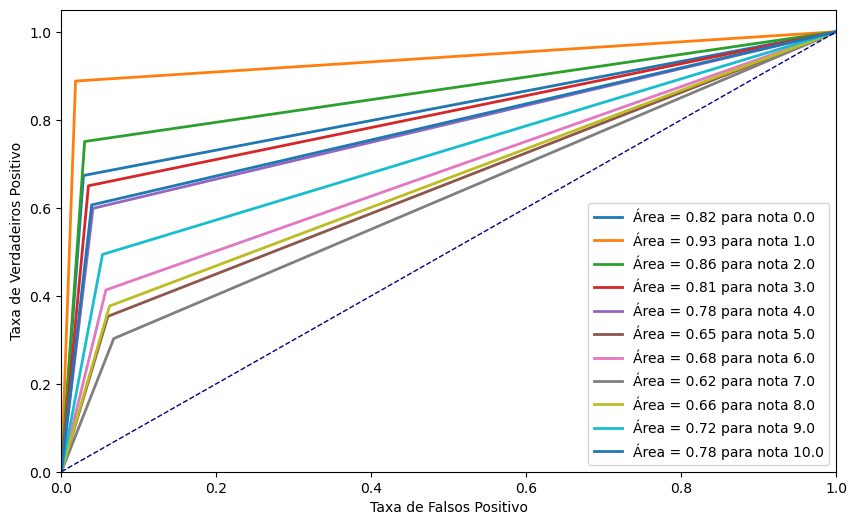

In [47]:
y1 = df1['SG1']
y2 = df2['SG1']
y3 = df3['SG1']
y4 = df4['SG1']
y5 = df5['SG1']

treinar_avaliar_modelo_ROC(X1,y1,'df1')
#treinar_avaliar_modelo_ROC(X2,y2,'df2')
#treinar_avaliar_modelo_ROC(X3,y3,'df3')
#treinar_avaliar_modelo_ROC(X4,y4,'df4')
#treinar_avaliar_modelo_ROC(X5,y5,'df5')

## UnderSampling

In [26]:
#Análise variável SG1 para undersampling
# Definir variável target
y6 = df6['SG1']
y7 = df7['SG1']
y8 = df8['SG1']
y9 = df9['SG1']
y10 = df10['SG1']


# Treinar e avaliar o modelo para cada dataset
treinar_avaliar_modelo(X6, y6, 'df6')
treinar_avaliar_modelo(X7, y7, 'df7')
treinar_avaliar_modelo(X8, y8, 'df8')
treinar_avaliar_modelo(X9, y9, 'df9')
treinar_avaliar_modelo(X10, y10, 'df10')


Matriz de Confusão para df6:
[[ 5  7  3  5  0  3  1  1  0  0  0]
 [ 6  3  6  5  4  2  0  0  0  0  0]
 [ 1  4  6  3  5  3  4  0  1  2  0]
 [ 4  5  5  3  3  3  1  2  0  1  1]
 [ 2  2  1  4  5  3  3  3  1  0  2]
 [ 2  0  1  4  5  1  5  2  2  1  2]
 [ 2  1  0  2  0  3 10  6  1  1  1]
 [ 1  1  2  1  2  4  5 10 10  4  1]
 [ 2  0  0  0  2  2  4  5  5  9  2]
 [ 1  0  0  1  0  0  1  1  2 16  6]
 [ 1  0  0  0  1  1  0  1  5  5  6]]
Acurácia do modelo para df6: 0.22875816993464052

Matriz de Confusão para df7:
[[5 5 6 1 3 2 1 0 1 1 1]
 [2 1 2 8 2 0 1 4 2 0 0]
 [4 1 4 4 7 4 2 5 1 0 0]
 [2 2 2 4 3 4 2 2 1 1 0]
 [1 4 7 4 1 5 2 6 0 1 0]
 [1 2 1 6 2 1 6 3 1 0 2]
 [2 0 2 1 1 2 7 2 1 2 2]
 [0 3 1 1 0 3 2 5 3 2 2]
 [0 0 2 2 4 1 4 4 4 2 2]
 [0 1 0 0 1 2 3 2 5 6 2]
 [0 1 1 2 2 1 2 2 4 7 8]]
Acurácia do modelo para df7: 0.16428571428571428

Matriz de Confusão para df8:
[[8 3 3 5 1 4 0 2 1 0 0]
 [6 1 8 2 2 2 0 0 1 3 1]
 [1 3 3 3 4 3 2 3 0 2 0]
 [6 3 4 1 5 1 3 3 2 2 0]
 [3 3 0 7 4 5 2 1 1 3 1]
 [2 1 4 7 3 0 

## Análise de importância das variáveis

In [22]:
# Função para treinar e avaliar importância de cada variável para o modelo
def importancia_variavel_modelo(X, y, nome_dataset):
    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Criar o modelo de árvore de decisão
    model = DecisionTreeClassifier(criterion='entropy')

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Faça previsões no conjunto de teste
    predictions = model.predict(X_test)

    # Avaliar a precisão do modelo
    accuracy = accuracy_score(y_test, predictions)
    print(f'Acurácia do modelo para {nome_dataset}: {accuracy}')

    # Calcule e imprima a importância das features
    feature_importance = model.feature_importances_

    # Crie um DataFrame para visualização
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Imprima a tabela de importância das features
    print("\nImportância das Features:")
    print(feature_importance_df)

# Criar DataFrames para cada dataset
df_bandlarg_res = pd.DataFrame(bandlarg_res)
df_telfix_res = pd.DataFrame(telfix_res)
df_tvass_res = pd.DataFrame(tvass_res)
df_pospago_res = pd.DataFrame(pospago_res)
df_prepago_res = pd.DataFrame(prepago_res)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

def importancia_Random_Forest(X, y, nome_dataset, test_size=0.2, random_state=42):
    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Criar o modelo de Random Forest
    model = RandomForestClassifier(n_estimators=100, random_state=random_state)

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Fazer previsões no conjunto de teste
    predictions = model.predict(X_test)

    # Avaliar a precisão do modelo
    accuracy = accuracy_score(y_test, predictions)
    print(f'Acurácia do modelo dataset {nome_dataset}: {accuracy}')

    # Calcular a importância das variáveis
    importances = model.feature_importances_

    # Extrair nomes das colunas
    feature_names = X.columns

    # Imprimir a importância de cada variável com seus respectivos nomes
    print("Importância das variáveis:")
    for name, importance in zip(feature_names, importances):
        print(f'Variável "{name}": {importance}')

# Exemplo de uso
import pandas as pd

df1 = pd.DataFrame(bandlarg_res)
df2 = pd.DataFrame(telfix_res)
df3 = pd.DataFrame(tvass_res)
df4 = pd.DataFrame(pospago_res)
df5 = pd.DataFrame(prepago_res)

X1 = df1[['MARCA','ESTADO','QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_1','QF1_2','QF1_3','QF1_4','QCR1_1','QCR1_2','P2','P2a','P7','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','PU7','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X2 = df2[['MARCA','ESTADO','QIC3','QF2_1','QF2_2','QF2_3','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X3 = df3[['MARCA','ESTADO','QIC3','QF3_1','QF3_2','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X4 = df4[['MARCA','ESTADO','QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_2','QF1_3','QF1_5','QF2_1','QCR1_1','QCR1_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X5 = df5[['MARCA','ESTADO','QIC1','QIC2','QF1_2','QF1_3','QF1_5','QF2_1','QCR2_1','QCR2_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]



In [31]:
# Acurácia modelo Random Forest para variável target SG1
y1 = df1['SG1']
y2 = df2['SG1']
y3 = df3['SG1']
y4 = df4['SG1']
y5 = df5['SG1']

importancia_Random_Forest(X1, y1, df1)
importancia_Random_Forest(X2, y2, df2)
importancia_Random_Forest(X3, y3, df3)
importancia_Random_Forest(X4, y4, df4)
importancia_Random_Forest(X5, y5, df5)

Acurácia do modelo dataset        MARCA  ESTADO  COD_IBGE  SG2  SG3  QIC1  QIC3  QA3_1  QA3_2  QA3_3  \
0          0       8   5211503    5    5     6     8      2      3      3   
1          0       8   5209937    7    9    10     8     10      9     10   
2          0       8   5211503   10   10    10     5      9      8      7   
3          0       8   5216304    8    6     5     4      5      7      5   
4          0       8   5204250    7    7     8     9     10     10     10   
...      ...     ...       ...  ...  ...   ...   ...    ...    ...    ...   
52982      3      17   4115200   10   10    10     2      9      9     10   
52983      1      15   2601326   10   10     9    10      9      9      9   
52984      4       8   5201405   10   10     8     8      8      8      8   
52985      4       0   1200272   10   10    10     8      5      5      6   
52986      2      17   4106678   10   10    10    10      8      8      8   

       ...  E1_3  E1_4  E1_5  ID1  ID2   ID3  ID

Acurácia do modelo dataset        MARCA  ESTADO  COD_IBGE  SG2  SG3  QIC1  QIC3  QA3_1  QA3_2  QA3_3  \
0          0       8   5211503    8    8     2    10     10     10      5   
1          0       8   5211503    6    3     7     6      3      0      4   
2          0       8   5211503    4    4     8     2      9      9      9   
3          0       8   5220405    9    9     8     8      7      6      7   
4          0       8   5211503    3    4     5     4      4      3      4   
...      ...     ...       ...  ...  ...   ...   ...    ...    ...    ...   
52036      2       6   5300108   10   10    10    10     10      8     10   
52037      9      25   3541204   10   10     8     8      8      8      8   
52038      5       0   1200333    8    8    10    10      5      4      5   
52039      5      22   4321760    9    9     9     9     10     10      9   
52040      0      10   3103515   10   10     9     9      9     10     10   

       ...  E1_3  E1_4  E1_5  ID1  ID2    ID3  I

In [23]:
# Variável target SG1
importancia_variavel_modelo(df_bandlarg_res[['QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_1','QF1_2','QF1_3','QF1_4','QCR1_1','QCR1_2','P2','P2a','P7','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','PU7','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], df_bandlarg_res['SG1'], 'bandlarg_res')
importancia_variavel_modelo(df_telfix_res[['QIC3','QF2_1','QF2_2','QF2_3','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], df_telfix_res['SG1'], 'telfix_res') 
importancia_variavel_modelo(df_tvass_res[['QIC3','QF3_1','QF3_2','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], df_tvass_res['SG1'], 'tvass_res') 
importancia_variavel_modelo(df_pospago_res[['QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_2','QF1_3','QF1_5','QF2_1','QCR1_1','QCR1_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], df_pospago_res['SG1'], 'pospago_res')  
importancia_variavel_modelo(df_prepago_res[['QIC1','QIC2','QF1_2','QF1_3','QF1_5','QF2_1','QCR2_1','QCR2_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], df_prepago_res['SG1'], 'prepago_res') 

Acurácia do modelo para bandlarg_res: 0.5678429892432535

Importância das Features:
   Feature  Importance
5    QF1_1    0.249721
0     QIC1    0.097658
44     ID3    0.052954
6    QF1_2    0.050169
1     QIC3    0.041211
8    QF1_4    0.039757
11      P2    0.037558
7    QF1_3    0.034070
2    QA3_1    0.033900
4    QA3_3    0.032988
3    QA3_2    0.031192
10  QCR1_2    0.029239
9   QCR1_1    0.028675
13      P7    0.024736
34     PU6    0.021990
42     ID1    0.020971
45    ID3a    0.020695
47      A1    0.019407
35     PU7    0.015242
43     ID2    0.014135
12     P2a    0.011191
19   QA4_1    0.008227
38    E1_2    0.007258
17   QA1_4    0.007052
16   QA1_3    0.007049
26   QA4_8    0.006928
46     ID5    0.006593
15   QA1_2    0.006451
18   QA1_5    0.006236
20   QA4_2    0.005938
23   QA4_5    0.005500
40    E1_4    0.004719
29  QA4_11    0.003768
32     PU3    0.003732
37    E1_1    0.003671
14   QA1_1    0.003481
31     PU2    0.003115
28  QA4_10    0.002823
41    E1_5    0.000

In [34]:
# Variável target SG2
importancia_variavel_modelo(df_bandlarg_res[['QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_1','QF1_2','QF1_3','QF1_4','QCR1_1','QCR1_2','P2','P2a','P7','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','PU7','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], df_bandlarg_res['SG2'], 'bandlarg_res')
importancia_variavel_modelo(df_telfix_res[['QIC3','QF2_1','QF2_2','QF2_3','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], df_telfix_res['SG2'], 'telfix_res') 
importancia_variavel_modelo(df_tvass_res[['QIC3','QF3_1','QF3_2','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], df_tvass_res['SG2'], 'tvass_res') 
importancia_variavel_modelo(df_pospago_res[['QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_2','QF1_3','QF1_5','QF2_1','QCR1_1','QCR1_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], df_pospago_res['SG2'], 'pospago_res')  
importancia_variavel_modelo(df_prepago_res[['QIC1','QIC2','QF1_2','QF1_3','QF1_5','QF2_1','QCR2_1','QCR2_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], df_prepago_res['SG2'], 'prepago_res') 

Acurácia do modelo para bandlarg_res: 0.501792791092659

Importância das Features:
   Feature  Importance
5    QF1_1    0.192603
0     QIC1    0.074537
11      P2    0.061683
44     ID3    0.060169
7    QF1_3    0.041199
1     QIC3    0.040630
6    QF1_2    0.037244
2    QA3_1    0.035715
9   QCR1_1    0.035606
8    QF1_4    0.035311
10  QCR1_2    0.034642
4    QA3_3    0.032968
47      A1    0.032008
3    QA3_2    0.031941
42     ID1    0.030375
45    ID3a    0.022549
43     ID2    0.017291
12     P2a    0.015834
13      P7    0.013199
19   QA4_1    0.013161
16   QA1_3    0.012376
35     PU7    0.011990
38    E1_2    0.011326
17   QA1_4    0.011137
18   QA1_5    0.010937
15   QA1_2    0.010848
46     ID5    0.010841
26   QA4_8    0.009753
20   QA4_2    0.009119
34     PU6    0.008052
23   QA4_5    0.007613
40    E1_4    0.006318
14   QA1_1    0.005211
37    E1_1    0.005140
28  QA4_10    0.005057
29  QA4_11    0.004296
32     PU3    0.000837
31     PU2    0.000484
41    E1_5    0.0000

In [35]:
# Variável target SG3
importancia_variavel_modelo(df_bandlarg_res[['QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_1','QF1_2','QF1_3','QF1_4','QCR1_1','QCR1_2','P2','P2a','P7','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','PU7','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], df_bandlarg_res['SG3'], 'bandlarg_res')
importancia_variavel_modelo(df_telfix_res[['QIC3','QF2_1','QF2_2','QF2_3','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], df_telfix_res['SG3'], 'telfix_res') 
importancia_variavel_modelo(df_tvass_res[['QIC3','QF3_1','QF3_2','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], df_tvass_res['SG3'], 'tvass_res') 
importancia_variavel_modelo(df_pospago_res[['QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_2','QF1_3','QF1_5','QF2_1','QCR1_1','QCR1_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], df_pospago_res['SG3'], 'pospago_res')  
importancia_variavel_modelo(df_prepago_res[['QIC1','QIC2','QF1_2','QF1_3','QF1_5','QF2_1','QCR2_1','QCR2_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], df_prepago_res['SG3'], 'prepago_res') 

Acurácia do modelo para bandlarg_res: 0.5317984525382148

Importância das Features:
   Feature  Importance
5    QF1_1    0.216527
0     QIC1    0.077359
11      P2    0.060125
44     ID3    0.056322
1     QIC3    0.040285
7    QF1_3    0.040171
6    QF1_2    0.036213
10  QCR1_2    0.034285
8    QF1_4    0.034110
3    QA3_2    0.033251
9   QCR1_1    0.032097
4    QA3_3    0.031727
2    QA3_1    0.030206
47      A1    0.029519
42     ID1    0.028961
45    ID3a    0.020952
12     P2a    0.015607
43     ID2    0.015131
19   QA4_1    0.012166
35     PU7    0.012091
46     ID5    0.011967
17   QA1_4    0.011839
13      P7    0.011384
16   QA1_3    0.010664
18   QA1_5    0.010296
38    E1_2    0.010019
34     PU6    0.009676
20   QA4_2    0.009261
15   QA1_2    0.008850
23   QA4_5    0.008804
26   QA4_8    0.008735
14   QA1_1    0.008458
40    E1_4    0.006862
37    E1_1    0.006418
29  QA4_11    0.004297
28  QA4_10    0.003659
32     PU3    0.000991
31     PU2    0.000715
36    QCR0    0.000

# Random Forest

In [14]:
def modelo_Random_Forest(X, y,nome_dataset, test_size=0.2, random_state=42):
    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Criar o modelo de Random Forest
    model = RandomForestClassifier(n_estimators=100, random_state=random_state)

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Fazer previsões no conjunto de teste
    predictions = model.predict(X_test)

    # Avaliar a precisão do modelo
    accuracy = accuracy_score(y_test, predictions)
    print(f'Acurácia do modelo dataset {nome_dataset}: {accuracy}')
    

    
# Criar dataframes para cada dataset
df1 = pd.DataFrame(bandlarg_res)
df2 = pd.DataFrame(telfix_res)
df3 = pd.DataFrame(tvass_res)
df4 = pd.DataFrame(pospago_res)
df5 = pd.DataFrame(prepago_res)

X1 = df1[['MARCA','ESTADO','QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_1','QF1_2','QF1_3','QF1_4','QCR1_1','QCR1_2','P2','P2a','P7','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','PU7','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X2 = df2[['MARCA','ESTADO','QIC3','QF2_1','QF2_2','QF2_3','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X3 = df3[['MARCA','ESTADO','QIC3','QF3_1','QF3_2','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X4 = df4[['MARCA','ESTADO','QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_2','QF1_3','QF1_5','QF2_1','QCR1_1','QCR1_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X5 = df5[['MARCA','ESTADO','QIC1','QIC2','QF1_2','QF1_3','QF1_5','QF2_1','QCR2_1','QCR2_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]


In [19]:
# Acurácia modelo Random Forest para variável target SG1
y1 = df1['SG1']
y2 = df2['SG1']
y3 = df3['SG1']
y4 = df4['SG1']
y5 = df5['SG1']

modelo_Random_Forest(X1,y1,'df1')
modelo_Random_Forest(X2,y2,'df2')
modelo_Random_Forest(X3,y3,'df3')
modelo_Random_Forest(X4,y4,'df4')
modelo_Random_Forest(X5,y5,'df5')

Acurácia do modelo dataset df1: 0.7540101906020004
Acurácia do modelo dataset df2: 0.7131329433124874
Acurácia do modelo dataset df3: 0.7132468700802159
Acurácia do modelo dataset df4: 0.767701027956576
Acurácia do modelo dataset df5: 0.7835905484349115


In [20]:
# Acurácia modelo Random Forest para variável target SG2
y1 = df1['SG2']
y2 = df2['SG2']
y3 = df3['SG2']
y4 = df4['SG2']
y5 = df5['SG2']

modelo_Random_Forest(X1,y1,'df1')
modelo_Random_Forest(X2,y2,'df2')
modelo_Random_Forest(X3,y3,'df3')
modelo_Random_Forest(X4,y4,'df4')
modelo_Random_Forest(X5,y5,'df5')

ValueError: Unknown label type: 'continuous'

In [21]:
# Acurácia modelo Random Forest para variável target SG3
y1 = df1['SG3']
y2 = df2['SG3']
y3 = df3['SG3']
y4 = df4['SG3']
y5 = df5['SG3']

modelo_Random_Forest(X1,y1,'df1')
modelo_Random_Forest(X2,y2,'df2')
modelo_Random_Forest(X3,y3,'df3')
modelo_Random_Forest(X4,y4,'df4')
modelo_Random_Forest(X5,y5,'df5')

ValueError: Unknown label type: 'continuous'

In [26]:
# Função calcular matriz de confusão
def Matriz_conf_RF(X, y, nome_dataset):
    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Criar o modelo de árvore de decisão
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Faça previsões no conjunto de teste
    predictions = model.predict(X_test)

    # Imprimir a matriz de confusão
    conf_matrix = confusion_matrix(y_test, predictions)
    print(f'\nMatriz de Confusão para {nome_dataset}:\n{conf_matrix}')

    # Avaliar a precisão do modelo
    accuracy = accuracy_score(y_test, predictions)
    print(f'Acurácia do modelo para {nome_dataset}: {accuracy}')

    
    
# Criar dataframes para cada dataset
df1 = pd.DataFrame(bandlarg_res)
df2 = pd.DataFrame(telfix_res)
df3 = pd.DataFrame(tvass_res)
df4 = pd.DataFrame(pospago_res)
df5 = pd.DataFrame(prepago_res)

X1 = df1[['MARCA','ESTADO','QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_1','QF1_2','QF1_3','QF1_4','QCR1_1','QCR1_2','P2','P2a','P7','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','PU7','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X2 = df2[['MARCA','ESTADO','QIC3','QF2_1','QF2_2','QF2_3','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X3 = df3[['MARCA','ESTADO','QIC3','QF3_1','QF3_2','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X4 = df4[['MARCA','ESTADO','QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_2','QF1_3','QF1_5','QF2_1','QCR1_1','QCR1_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]
X5 = df5[['MARCA','ESTADO','QIC1','QIC2','QF1_2','QF1_3','QF1_5','QF2_1','QCR2_1','QCR2_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']]


In [23]:
#Matriz de confusão variável SG1
y1 = df1['SG1']
y2 = df2['SG1']
y3 = df3['SG1']
y4 = df4['SG1']
y5 = df5['SG1']

Matriz_conf_RF(X1, y1, 'df1')
Matriz_conf_RF(X2, y2, 'df2')
Matriz_conf_RF(X3, y3, 'df3')
Matriz_conf_RF(X4, y4, 'df4')
Matriz_conf_RF(X5, y5, 'df5')


Matriz de Confusão para df1:
[[877   8  11  16  17  10  13   6   2   3   1]
 [  7 894   1   1   1   3   2   0   0   1   0]
 [ 19   4 949   7  11  11  15   3   3   3   1]
 [  8   4   8 897  16  13  14   6   6   2   0]
 [ 19   3   5  12 841  26  25  15   2   0   1]
 [ 36   6  19  42  59 564  95  84  39  10   6]
 [  5   0   5  16  31  76 659 101  52  16   5]
 [  6   0   3   4  13  83 123 469 219  42  26]
 [  3   0   1   2   4  34  29 161 533 123  98]
 [  0   0   0   0   0   5   9  27 178 599 138]
 [  0   1   0   0   0   9   5   9  68 116 709]]
Acurácia do modelo para df1: 0.7540101906020004

Matriz de Confusão para df2:
[[783   2  18  15  18  16   9   9   8   8   4]
 [  3 858   1   1   2   2   0   2   0   2   1]
 [ 27   2 839   3   8   8  20  12   5   9   3]
 [ 15   4   3 851  17  16  28   8   5   9   0]
 [ 15   4  12   8 792  12  16  21   9  11   2]
 [ 57   6  17  31  37 441  74  71  78  40  35]
 [ 11   4  11  22  28  42 600  60  53  43  17]
 [ 16   1   6   7  19  71  94 389 156  90  64

In [27]:
#Matriz de confusão variável SG2
y1 = df1['SG2']
y2 = df2['SG2']
y3 = df3['SG2']
y4 = df4['SG2']
y5 = df5['SG2']

Matriz_conf_RF(X1, y1, 'df1')
Matriz_conf_RF(X2, y2, 'df2')
Matriz_conf_RF(X3, y3, 'df3')
Matriz_conf_RF(X4, y4, 'df4')
Matriz_conf_RF(X5, y5, 'df5')


Matriz de Confusão para df1:
[[1252   48    5    7    6   26    0    7    8    4    6]
 [ 111  611   74   10    5   23    0    7    3    3    3]
 [  30   61  584   80   16   35    2    6    5    2    0]
 [  33   10   72  559   82   62    9   12    9    1    2]
 [  27    6    7   83  520  146    7   19    7    1    3]
 [  39    3    9   22   86  778   60   69   62   14   26]
 [  12    1    4    6   21  182  269  112   50   15   12]
 [   8    0    4    5    9  138   89  332  185   55   45]
 [   5    2    3    1    4   75   31  158  373  171  166]
 [   2    0    0    1    0   15    4   39  156  453  235]
 [   5    0    0    1    0   18    2   23   88  138  990]]
Acurácia do modelo para df1: 0.6341762596716362

Matriz de Confusão para df2:
[[906  34   8   7   2  26   6   7  22   9  18]
 [ 67 589  65   9   8  18   5   3   3   0   6]
 [ 35  52 601  72  15  25   7  10   3  10  11]
 [ 19  10  76 493  65  38  10  10  13   2   8]
 [ 14  16  15  81 595  98  16   7  14  14  15]
 [ 47  11  14  22 

In [28]:
#Matriz de confusão variável SG2
y1 = df1['SG3']
y2 = df2['SG3']
y3 = df3['SG3']
y4 = df4['SG3']
y5 = df5['SG3']

Matriz_conf_RF(X1, y1, 'df1')
Matriz_conf_RF(X2, y2, 'df2')
Matriz_conf_RF(X3, y3, 'df3')
Matriz_conf_RF(X4, y4, 'df4')
Matriz_conf_RF(X5, y5, 'df5')


Matriz de Confusão para df1:
[[2928   34    3    5    2   37    3   13    9    2    5]
 [ 218  411   36    3    3   19    1    1    2    0    2]
 [ 129   66  344   49    9   29    2    9    4    1    2]
 [ 125    3   50  251   50   52    3   16    7    1    4]
 [ 114    4    7   55  267  120    8   21    7    2    9]
 [ 116    0    7   12   64  524   56   56   59    6   26]
 [  50    1    2    2    8  159  151  103   73   14   16]
 [  35    0    0    1    3  113   56  231  204   44   43]
 [  13    0    0    0    1   65    7  116  345  154  147]
 [   5    0    1    0    0   20    5   31  154  377  199]
 [   7    0    0    0    0   18    0   14   87  111  929]]
Acurácia do modelo para df1: 0.6376674844310247

Matriz de Confusão para df2:
[[2223   34    4    1    4   29    8   10   26    9   35]
 [ 221  488   38    5    2   24    2    4    4    2    2]
 [ 125   50  387   39    5   31    2    8    9    5    6]
 [  93    6   61  297   40   42    5   10   20    6    8]
 [  67    5   10   59

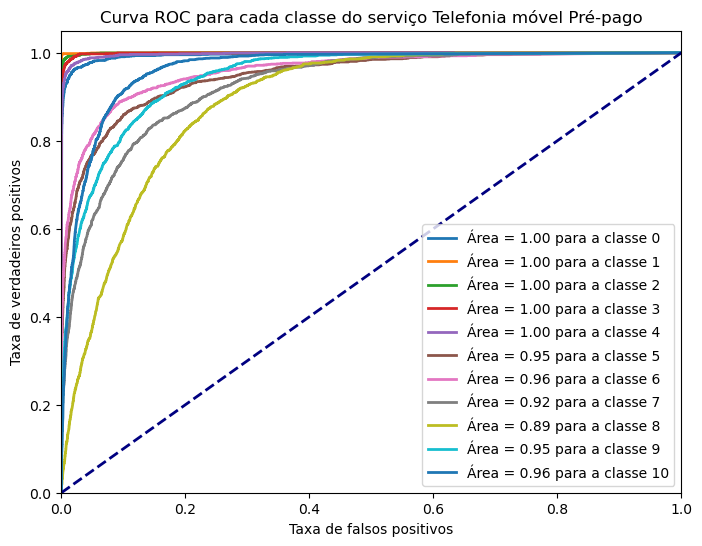

In [33]:
#Plotar curva ROC DF Banda larga 
y5 = df5['SG1']

# Divida os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X5, y5, test_size=0.3, random_state=42)

# Ajuste o modelo OneVsRestClassifier com RandomForestClassifier
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf.fit(X_train, y_train)

# Calcule as probabilidades previstas
y_score = clf.predict_proba(X_test)

# Calcule a curva ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(clf.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test.map(lambda x: 1 if x == clf.classes_[i] else 0), y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote a curva ROC para cada classe
plt.figure(figsize=(8, 6))
for i in range(len(clf.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label='Área = %0.2f para a classe %s' % (roc_auc[i], clf.classes_[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falsos positivos')
plt.ylabel('Taxa de verdadeiros positivos')
plt.title('Curva ROC para cada classe do serviço Telefonia móvel Pré-pago')
plt.legend(loc="lower right")
plt.savefig('Curva_ROC_RF_df5.png', dpi=1000)

plt.show()




In [19]:

# Função para plotar a curva ROC
def plot_roc_curve(fpr, tpr, roc_auc, dataset_idx):
    plt.figure()
    for i in range(len(fpr)):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Área = {roc_auc[i]:.2f}) para a nota {i}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de falso positivos')
    plt.ylabel('Taxa de positivos verdadeiros')
    plt.title(f'Curva ROC para o serviço {dataset_idx}')
    plt.legend(loc="lower right")
    plt.show()

    
df1 = pd.DataFrame(bandlarg_res)
df2 = pd.DataFrame(telfix_res)
df3 = pd.DataFrame(tvass_res)
df4 = pd.DataFrame(pospago_res)
df5 = pd.DataFrame(prepago_res)

# Datasets
datasets = [
    (pd.DataFrame(bandlarg_res), pd.DataFrame(bandlarg_res)[['MARCA','ESTADO','QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_1','QF1_2','QF1_3','QF1_4','QCR1_1','QCR1_2','P2','P2a','P7','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','PU7','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], 'df1'),
    (pd.DataFrame(telfix_res), pd.DataFrame(telfix_res)[['MARCA','ESTADO','QIC3','QF2_1','QF2_2','QF2_3','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], 'df2'),
    (pd.DataFrame(tvass_res), pd.DataFrame(tvass_res)[['MARCA','ESTADO','QIC3','QF3_1','QF3_2','QCR1_1','QCR1_2','P2','P2a','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], 'df3'),
    (pd.DataFrame(pospago_res), pd.DataFrame(pospago_res)[['MARCA','ESTADO','QIC1','QIC3','QA3_1','QA3_2','QA3_3','QF1_2','QF1_3','QF1_5','QF2_1','QCR1_1','QCR1_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','QCR0','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], 'df4'),
    (pd.DataFrame(prepago_res), pd.DataFrame(prepago_res)[['MARCA','ESTADO','QIC1','QIC2','QF1_2','QF1_3','QF1_5','QF2_1','QCR2_1','QCR2_2','P2','P2a','P6','QA1_1','QA1_2','QA1_3','QA1_4','QA1_5','QA4_1','QA4_2','QA4_3','QA4_4','QA4_5','QA4_6','QA4_7','QA4_8','QA4_9','QA4_10','QA4_11','PU1','PU2','PU3','PU5','PU6','E1_1','E1_2','E1_3','E1_4','E1_5','ID1','ID2','ID3','ID3a','ID5','A1']], 'df5')
]

In [ ]:
# Loop para calcular e plotar a curva ROC para cada DataFrame
for idx, (df, X, df_name) in enumerate(datasets):
    # Divida os dados em conjunto de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, df['SG1'], test_size=0.3, random_state=42)

    # Ajuste o modelo OneVsRestClassifier com RandomForestClassifier
    clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
    clf.fit(X_train, y_train)

    # Calcule as probabilidades previstas
    y_score = clf.predict_proba(X_test)

    # Calcule a curva ROC para cada classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(clf.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test.map(lambda x: 1 if x == clf.classes_[i] else 0), y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plote a curva ROC para cada classe
    print(f"AUC para {df_name}: {roc_auc}")
    plot_roc_curve([fpr[i] for i in range(len(clf.classes_))], [tpr[i] for i in range(len(clf.classes_))], [roc_auc[i] for i in range(len(clf.classes_))], df_name)


AUC para df1: {0: 0.9811717433598071, 1: 0.9585510642278257, 2: 0.9465106779774284, 3: 0.9374679254431215, 4: 0.9269742138276412, 5: 0.8883686883774067, 6: 0.8766659099486214, 7: 0.877376858774035, 8: 0.87504592064292, 9: 0.9248080557504078, 10: 0.9610064413059389}


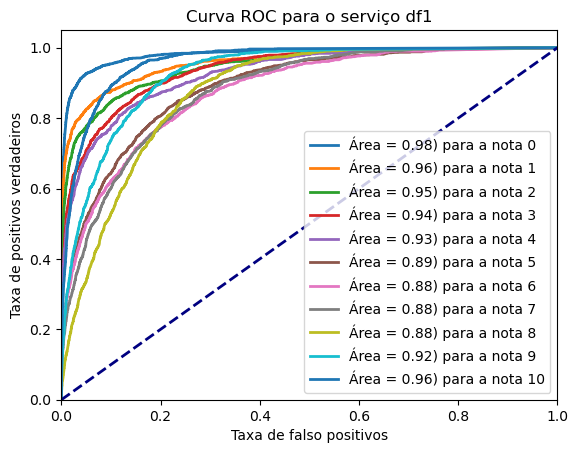

AUC para df2: {0: 0.9634537868423674, 1: 0.9477646579608672, 2: 0.9306596522947187, 3: 0.9026457028016011, 4: 0.9085368193187642, 5: 0.863438189371765, 6: 0.8630024463127266, 7: 0.8401682543419513, 8: 0.8399420392467609, 9: 0.9018990166148966, 10: 0.9424374220525359}


<Figure size 640x480 with 0 Axes>

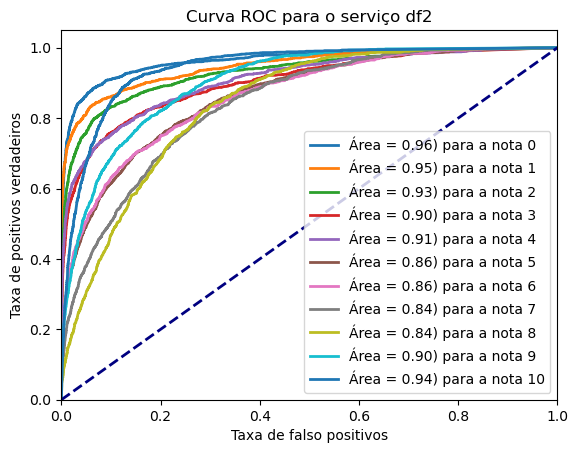

AUC para df3: {0: 0.9667617853125583, 1: 0.9466191015614995, 2: 0.928548708247203, 3: 0.9169552142513829, 4: 0.9009546364465975, 5: 0.8628423732963736, 6: 0.8478704669407686, 7: 0.8390406351297085, 8: 0.8475843914388085, 9: 0.9016203893237821, 10: 0.9458268027992647}


<Figure size 640x480 with 0 Axes>

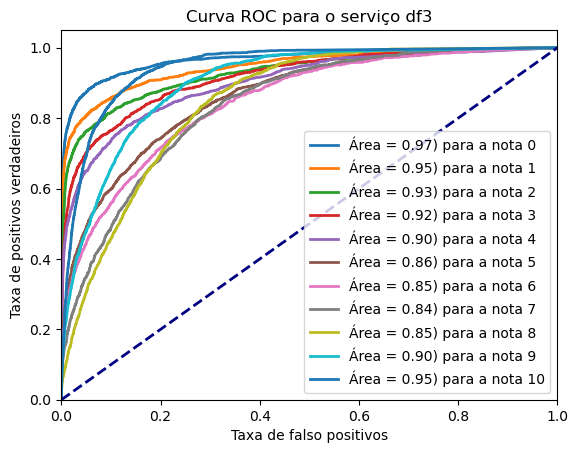

AUC para df4: {0: 0.9816399706193139, 1: 0.9647888059822047, 2: 0.9541011061001835, 3: 0.93624716126915, 4: 0.9290252602838973, 5: 0.8979038327620604, 6: 0.8716569552229517, 7: 0.8709582308093236, 8: 0.8641393645782094, 9: 0.9185620487474471, 10: 0.9547951098967445}


<Figure size 640x480 with 0 Axes>

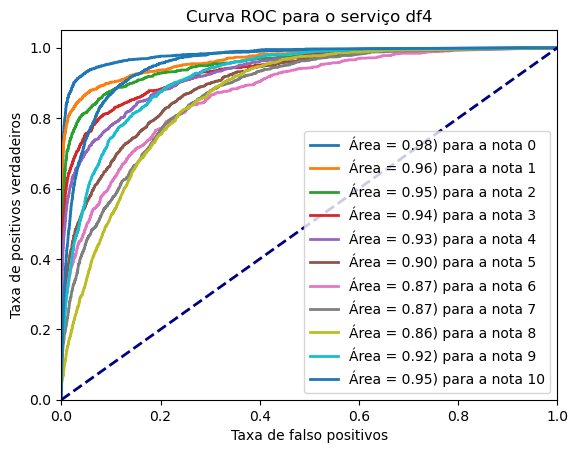

AUC para df5: {0: 0.9914165630137552, 1: 0.9807738653288328, 2: 0.9736174802973042, 3: 0.9649553746249429, 4: 0.9598808714926987, 5: 0.9268496872346541, 6: 0.9044385759650799, 7: 0.8990777930798131, 8: 0.8605322022196462, 9: 0.9060209857787533, 10: 0.9496260083434989}


<Figure size 640x480 with 0 Axes>

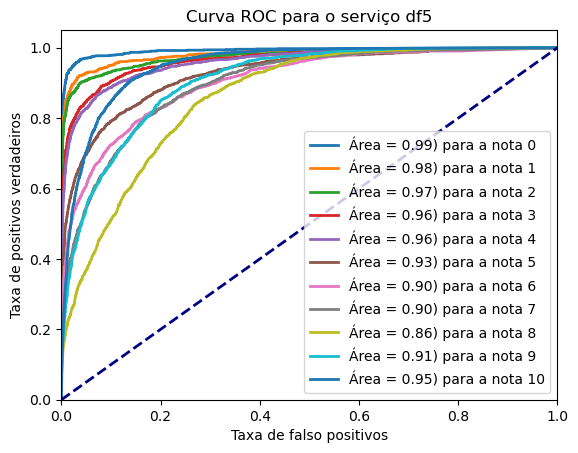

<Figure size 640x480 with 0 Axes>

In [22]:
# Loop para calcular e plotar a curva ROC para cada DataFrame
for idx, (df, X, df_name) in enumerate(datasets):
    # Divida os dados em conjunto de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, df['SG2'], test_size=0.3, random_state=42)

    # Ajuste o modelo OneVsRestClassifier com RandomForestClassifier
    clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
    clf.fit(X_train, y_train)

    # Calcule as probabilidades previstas
    y_score = clf.predict_proba(X_test)

    # Calcule a curva ROC para cada classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(clf.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test.map(lambda x: 1 if x == clf.classes_[i] else 0), y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plote a curva ROC para cada classe
    print(f"AUC para {df_name}: {roc_auc}")
    plot_roc_curve([fpr[i] for i in range(len(clf.classes_))], [tpr[i] for i in range(len(clf.classes_))], [roc_auc[i] for i in range(len(clf.classes_))], df_name)
    plt.savefig('Curva_ROC_RF.png', dpi=1000)

AUC para df1: {0: 0.9811717433598071, 1: 0.9585510642278257, 2: 0.9465106779774284, 3: 0.9374679254431215, 4: 0.9269742138276412, 5: 0.8883686883774067, 6: 0.8766659099486214, 7: 0.877376858774035, 8: 0.87504592064292, 9: 0.9248080557504078, 10: 0.9610064413059389}


TypeError: plot_roc_curve() got an unexpected keyword argument 'ax'

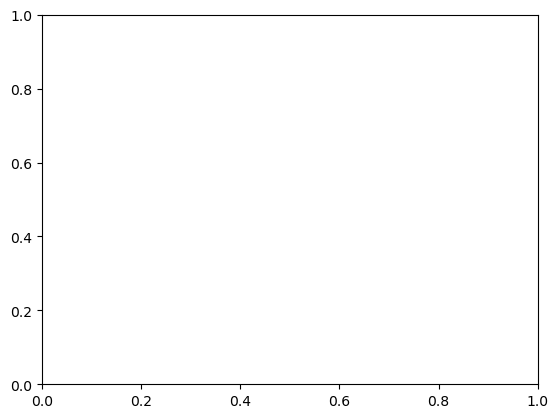

In [25]:
import matplotlib.pyplot as plt

# Loop para calcular e plotar a curva ROC para cada DataFrame
for idx, (df, X, df_name) in enumerate(datasets):
    # Divida os dados em conjunto de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, df['SG2'], test_size=0.3, random_state=42)

    # Ajuste o modelo OneVsRestClassifier com RandomForestClassifier
    clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
    clf.fit(X_train, y_train)

    # Calcule as probabilidades previstas
    y_score = clf.predict_proba(X_test)

    # Calcule a curva ROC para cada classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(clf.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test.map(lambda x: 1 if x == clf.classes_[i] else 0), y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plote a curva ROC para cada classe
    print(f"AUC para {df_name}: {roc_auc}")
    
    # Create a new figure and axes
    fig, ax = plt.subplots()

    # Plot the ROC curve
    plot_roc_curve([fpr[i] for i in range(len(clf.classes_))], [tpr[i] for i in range(len(clf.classes_))], [roc_auc[i] for i in range(len(clf.classes_))], df_name, ax=ax)
    
    # Save the plot to a file
    plt.savefig(f'{df_name}_ROC_curve.png')
    
    # Close the figure to free up memory
    plt.close(fig)


AUC para df1: {0: 0.9939145398868073, 1: 0.9997404695834566, 2: 0.9960479730224218, 3: 0.9947409329594776, 4: 0.9906353528634062, 5: 0.931392527183644, 6: 0.9423823141165197, 7: 0.91066480545695, 8: 0.915198034027805, 9: 0.9546795466653164, 10: 0.9739030608647362}


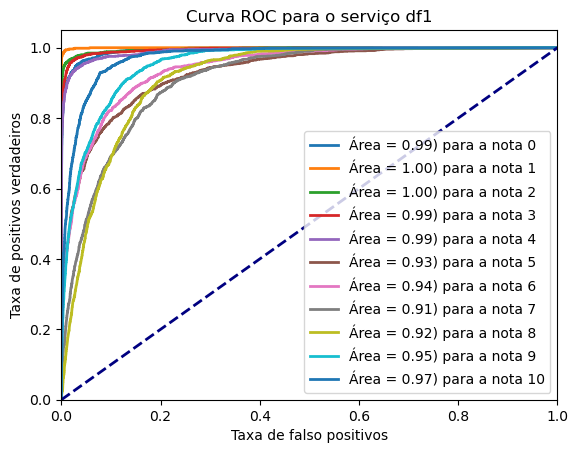

AUC para df2: {0: 0.9822743268138243, 1: 0.9996935334786824, 2: 0.9912947223472688, 3: 0.9905535380743559, 4: 0.9884572246022432, 5: 0.9080756304798556, 6: 0.9440510691188051, 7: 0.8960825966543716, 8: 0.8771476681648229, 9: 0.9380748759285471, 10: 0.9479169566287431}


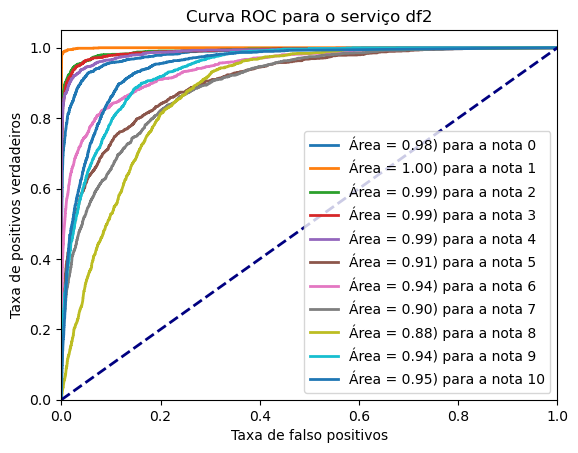

AUC para df3: {0: 0.9868158625637423, 1: 0.9995807468962755, 2: 0.996676980379837, 3: 0.9933182685962578, 4: 0.9895084087171059, 5: 0.9125579017885755, 6: 0.9309553011596916, 7: 0.8921315657703722, 8: 0.875064232313113, 9: 0.9300221281368777, 10: 0.9509860520205089}


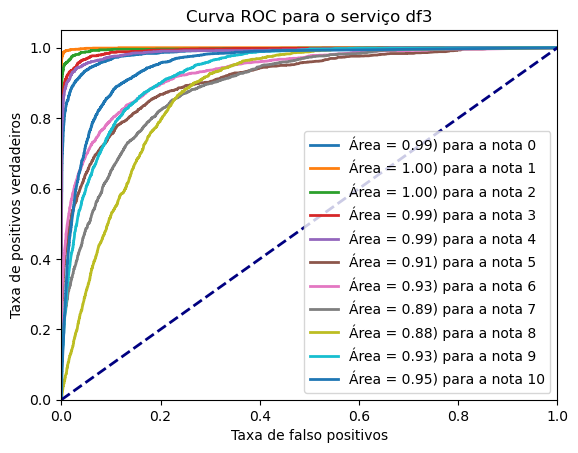

AUC para df4: {0: 0.9958482714379462, 1: 0.9999172256450038, 2: 0.9989165076274832, 3: 0.9974755538719968, 4: 0.9934464769357212, 5: 0.9449836923179185, 6: 0.9520227202282077, 7: 0.9055290643593559, 8: 0.905049477253225, 9: 0.9512105411819349, 10: 0.9597901133180337}


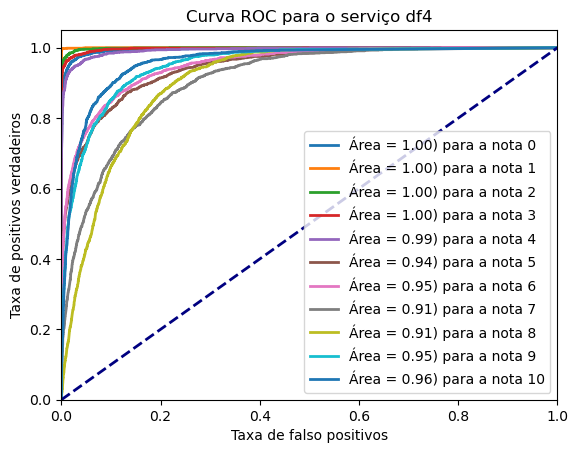

AUC para df5: {0: 0.9957188997572375, 1: 0.9998370581627091, 2: 0.9992392312767516, 3: 0.9987468219627712, 4: 0.9974331985457205, 5: 0.948427659934878, 6: 0.9583518550817821, 7: 0.9242954903955656, 8: 0.8891292134387374, 9: 0.9456897944179483, 10: 0.9636909057926729}


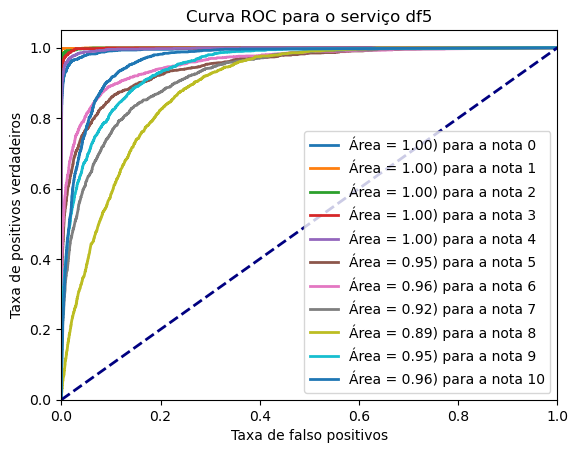

In [21]:
# Loop para calcular e plotar a curva ROC para cada DataFrame
for idx, (df, X, df_name) in enumerate(datasets):
    # Divida os dados em conjunto de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, df['SG1'], test_size=0.3, random_state=42)

    # Ajuste o modelo OneVsRestClassifier com RandomForestClassifier
    clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
    clf.fit(X_train, y_train)

    # Calcule as probabilidades previstas
    y_score = clf.predict_proba(X_test)

    # Calcule a curva ROC para cada classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(clf.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test.map(lambda x: 1 if x == clf.classes_[i] else 0), y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plote a curva ROC para cada classe
    print(f"AUC para {df_name}: {roc_auc}")
    plot_roc_curve([fpr[i] for i in range(len(clf.classes_))], [tpr[i] for i in range(len(clf.classes_))], [roc_auc[i] for i in range(len(clf.classes_))], df_name)


TypeError: Image data of dtype <U19 cannot be converted to float

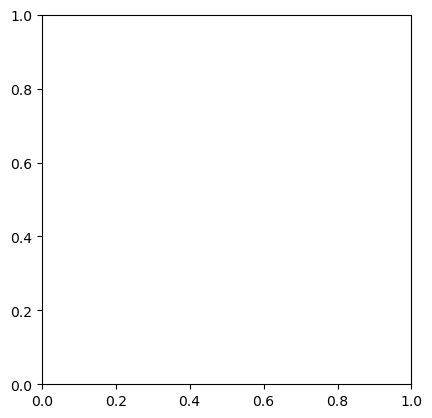

In [3]:
import matplotlib.pyplot as plt

# Criar uma matriz de confusão simples
confusion_matrix = [["Verdadeiro Positivo", 10], [5, 35]]  # Exemplo de uma matriz de confusão

# Plotar a matriz de confusão
plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')

# Adicionar rótulos aos eixos
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')

# Adicionar anotações aos elementos da matriz
for i in range(len(confusion_matrix)):
    for j in range(len(confusion_matrix[0])):
        plt.text(j, i, str(confusion_matrix[i][j]), ha='center', va='center')

# Adicionar uma barra de cores
plt.colorbar()

# Mostrar o gráfico
plt.show()
